# **Installing Libraries**

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip uninstall opencv-python-headless==4.5.5.62 -y
!pip install opencv-python-headless

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-3yr19u40
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-3yr19u40
  Resolved https://github.com/albu/albumentations to commit c9e5afaf39415af4d013546ffbdff707b6030561
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)


# **Imports**

In [ ]:
from google.colab import drive
import zipfile,os
import sys
import numpy as np
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted

from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import albumentations as A

import random
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
# from keras_unet_collection import models, losses , base
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,Concatenate,concatenate,Conv2DTranspose,Dropout,Add,Activation, UpSampling2D, Multiply, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import f1_score,accuracy_score,precision_score, recall_score, jaccard_score

In [ ]:
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/Dental-Segementation-and-Enumeration/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class PreprocessDataset:
  def __init__(self):
    self.aug = A.Compose([
            A.OneOf([A.RandomCrop(width=256, height=256),
                      A.PadIfNeeded(min_height=256, min_width=256, p=0.5)], p=0.4),
            A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
            A.Compose([A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
                        A.Resize(256, 256, cv2.INTER_NEAREST)], p=0.5),
            A.ShiftScaleRotate(shift_limit=0.325, scale_limit=0.15, rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=1),
            A.Rotate(15, p=0.5),
            A.Blur(blur_limit=1, p=0.5),
            A.Downscale(scale_min=0.15, scale_max=0.25, always_apply=False, p=0.5),
            A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, always_apply=False, p=0.5),
            A.HorizontalFlip(p=0.25),
        ])

  def convert_one_channel(self,img):
    # some images have 3 channels , although they are grayscale image
    if len(img.shape) > 2:
        img = img[:, :, 0]
        return img
    else:
        return img

  def load_images(self,resize_shape, path):
    dirs = natsorted(os.listdir(path))
    sizes = np.zeros([len(dirs), 2])
    images = []
    for i in range(len(dirs)):
        img = Image.open(path+dirs[i])
        sizes[i, :] = img.size
        img = img.resize((resize_shape), Image.ANTIALIAS)
        img = self.convert_one_channel(np.asarray(img))
        images.append(img)
    images = np.stack(images, axis=0)
    images = np.expand_dims(images, axis=-1)
    return images, sizes

  def load_masks(self,resize_shape=(512, 512), path=""):
    dirs = natsorted(os.listdir(path))
    masks = []
    for i in range(len(dirs)):
        img = Image.open(path+dirs[i])
        img = img.resize((resize_shape), Image.ANTIALIAS)
        img = self.convert_one_channel(np.asarray(img))
        masks.append(img)
    masks = np.stack(masks, axis=0)
    masks = np.expand_dims(masks, axis=-1)
    return masks

  def load_splitted_masks(self,path):
    dirs = natsorted(os.listdir(path))
    masks = []
    for i in range(len(dirs)):
        img = Image.open(path+dirs[i])
        img = self.convert_one_channel(np.asarray(img))
        masks.append(img)
    masks = np.stack(masks, axis=0)
    masks = np.expand_dims(masks, axis=-1)
    return masks
  def normalize_images(self,images):
    return np.float32(images/255)

  def augment_data(self, x_train, y_train, augment_factor=4):
    x_train_aug = np.copy(x_train)
    y_train_aug = np.copy(y_train)

    for count in range(augment_factor):
        x_aug = np.copy(x_train_aug)
        y_aug = np.copy(y_train_aug)
        for i in range(len(x_train_aug)):
            augmented = self.aug(image=x_train_aug[i], mask=y_train_aug[i])
            x_aug[i] = augmented['image']
            y_aug[i] = augmented['mask']
        x_train = np.concatenate((x_train, x_aug))
        y_train = np.concatenate((y_train, y_aug))

    return x_train, y_train


In [ ]:
processor = PreprocessDataset()

images,images_sizes=processor.load_images((256,256),drive_path+"data/Radiographs/")
masks = processor.load_masks(resize_shape=(256,256),path=drive_path+'data/Segmentation/teeth_mask/')

<ipython-input-4-3dbeef6385b7>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((resize_shape), Image.ANTIALIAS)
<ipython-input-4-3dbeef6385b7>:44: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((resize_shape), Image.ANTIALIAS)


In [ ]:
normalized_images = processor.normalize_images(images)
normalized_masks = processor.normalize_images(masks)

x_normalized_images, normalized_images_test, y_normalized_masks, normalized_masks_test = train_test_split(normalized_images, normalized_masks , test_size=0.2, random_state=42)
normalized_images_train, normalized_images_val, normalized_masks_train, normalized_masks_val = train_test_split(x_normalized_images, y_normalized_masks, test_size=0.25, random_state=42)

In [ ]:
print(f"Training data: {len(normalized_images_train)} images")
print(f"Validation data: {len(normalized_images_val)} images")
print(f"Test data: {len(normalized_images_test)} images")

Training data: 600 images
Validation data: 200 images
Test data: 200 images


In [ ]:
normalized_images_train, normalized_masks_train = processor.augment_data(normalized_images_train,normalized_masks_train)

In [ ]:
class Visualization:
  def visualize_images(self,test_image, true_mask, predicted_mask):
    plt.figure(figsize=(18, 6))

    # Displaying the test image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title('Test Image')
    plt.axis('off')

    # Displaying the true mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Segmentation Mask')
    plt.axis('off')

    # Displaying the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Segmentation Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

  def detailed_visualization(self,test_image, true_mask, predicted_mask):
    plt.figure(figsize=(20, 10))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title('Test Image')
    plt.axis('off')

    # True Mask
    plt.subplot(2, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Segmentation Mask')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(2, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Segmentation Mask')
    plt.axis('off')

    # Overlay of Predicted on Image
    overlay = np.stack([test_image]*3, axis=-1)
    where_mask = np.where(predicted_mask > 0.5)
    overlay[where_mask[0], where_mask[1], :] = [255, 0, 0]
    plt.subplot(2, 3, 4)
    plt.imshow(overlay)
    plt.title('Overlay of Predicted on Image')
    plt.axis('off')

    # Difference between Predicted and True
    difference = np.abs(predicted_mask - true_mask)
    plt.subplot(2, 3, 5)
    plt.imshow(difference, cmap='jet')  # Using a different colormap to highlight differences
    plt.title('Difference between True and Predicted')
    plt.axis('off')

    # Histogram of Predicted Values
    plt.subplot(2, 3, 6)
    plt.hist(predicted_mask.ravel(), bins=50)
    plt.title('Histogram of Predicted Values')

    plt.tight_layout()
    plt.show()

  def advanced_visualization(self,test_image, true_mask, predicted_mask, threshold=0.5):
    # Binary conversion of predicted_mask
    binary_predicted_mask = (predicted_mask > threshold).astype(np.uint8)

    # Normalize test_image to [0, 1] if it's float
    if test_image.dtype == np.float32 or test_image.dtype == np.float64:
        test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())

    # Errors
    false_positives = np.where((binary_predicted_mask == 1) & (true_mask == 0))
    false_negatives = np.where((binary_predicted_mask == 0) & (true_mask == 1))

    plt.figure(figsize=(20, 10))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title('Test Image')
    plt.axis('off')

    # True vs Predicted Masks
    overlay = np.stack([test_image]*3, axis=-1)
    overlay[false_positives[0], false_positives[1], :] = [1, 0, 0]
    overlay[false_negatives[0], false_negatives[1], :] = [0, 0, 1]
    plt.subplot(2, 3, 2)
    plt.imshow(overlay)
    plt.title('Errors Highlighted (FP=Red, FN=Blue)')
    plt.axis('off')

    # Zoomed Region
    # (Modify these to focus on a specific region of interest)
    zoom_region = (slice(100, 200), slice(100, 200))
    plt.subplot(2, 3, 3)
    plt.imshow(test_image[zoom_region], cmap='gray')
    plt.title('Zoomed Region of Test Image')
    plt.axis('off')

    # Confusion Matrix
    cm = confusion_matrix(true_mask.astype(np.uint8).flatten(), binary_predicted_mask.flatten())
    plt.subplot(2, 3, 4)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

  def plot_images_with_masks(images, masks, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

    for i in range(num_images):
        ax_img = axes[i, 0]
        ax_mask = axes[i, 1]

        ax_img.imshow(images[i].squeeze(), cmap='gray')
        ax_img.set_title('Unlabeled Image')
        ax_img.axis('off')

        ax_mask.imshow(masks[i].squeeze(), cmap='gray')
        ax_mask.set_title('Pseudo-Label Mask')
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
class ModelManager:

  def train(self,model,x_train,y_train,x_val, y_val,batch_size=8,epochs=5,verbose=1,metrics = ['accuracy']):
    model.summary()
    # Define early stopping criteria
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = metrics)
    # Train the model
    # history = model.fit(x_train,y_train,
    #                     validation_data=(x_val, y_val),
    #                     batch_size=batch_size,epochs=epochs,verbose=verbose)
    history = model.fit(x_train,y_train,
                        validation_data=(x_val, y_val),
                        batch_size=batch_size,epochs=epochs,verbose=verbose,callbacks=[early_stopping])
    return model, history

  def save_model(self,model,path):
    tf.keras.models.save_model(model, path)

  def load_model(self,path):
    return tf.keras.models.load_model(path)

  def predict(self,model,images):
    predictions = model.predict(images)
    return predictions

  def evaluation_metrics(self,predicted_values, true_values):
    predicted_values=(predicted_values>0.25)*1
    true_values=(true_values>0.25)*1

    true_values_flat = true_values.flatten()
    predicted_values_flat = predicted_values.flatten()

    # F1 Score
    f1 = f1_score(true_values_flat,predicted_values_flat, average='binary')
    # Accuracy
    accuracy = accuracy_score(true_values_flat, predicted_values_flat)
    # Dice Score
    dice_score = (2 * np.sum(predicted_values * true_values)) / (np.sum(predicted_values) + np.sum(true_values))

    precision = precision_score(true_values_flat, predicted_values_flat)
    # Recall
    recall = recall_score(true_values_flat, predicted_values_flat)
    # Jaccard Coefficient
    jaccard_coefficient = jaccard_score(true_values_flat, predicted_values_flat)
    # IOU
    intersection = np.sum(true_values_flat & predicted_values_flat)
    union = np.sum(true_values_flat | predicted_values_flat)
    iou = intersection / union

    print("Evaluation Metrics:")
    print("="*50)
    print(f"{'Metric':<25}{'Value':<25}")
    print("="*50)
    print(f"{'F1 Score:':<25}{f1:.4f}")
    print(f"{'Accuracy:':<25}{accuracy:.4f}")
    print(f"{'Dice Score:':<25}{dice_score:.4f}")
    print(f"{'Precision:':<25}{precision:.4f}")
    print(f"{'Recall:':<25}{recall:.4f}")
    print(f"{'Jaccard Coefficient (IoU):':<25}{jaccard_coefficient:.4f}")
    print(f"{'Intersection over Union (IoU):':<25}{iou:.4f}")
    print("="*50)

  def get_pseudolabels(self, model, images, confidence_threshold=0.9):
    pseudo_labels = model.predict(images, batch_size=16)
    pseudo_labels_confident = (pseudo_labels > confidence_threshold).astype(np.float32)
    return pseudo_labels_confident

  def perform_semi_supervised_learning(self, model, unlabeled_images):
    # Perform pseudolabeling
    pseudo_labels_confident = self.get_pseudolabels(model, unlabeled_images, 0.9 )
    return pseudo_labels_confident

## **UNET Models Class**

In [ ]:
class UNetModels:

  def unet (self, input_shape=(512,512,1),last_activation='sigmoid'):
    inputs=Input(shape=input_shape)

    conv1 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    d1=Dropout(0.1)(conv1)
    conv2 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d1)
    b=BatchNormalization()(conv2)

    pool1 = MaxPooling2D(pool_size=(2, 2))(b)
    conv3 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    d2=Dropout(0.2)(conv3)
    conv4 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d2)
    b1=BatchNormalization()(conv4)

    pool2 = MaxPooling2D(pool_size=(2, 2))(b1)
    conv5 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    d3=Dropout(0.3)(conv5)
    conv6 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d3)
    b2=BatchNormalization()(conv6)

    pool3 = MaxPooling2D(pool_size=(2, 2))(b2)
    conv7 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    d4=Dropout(0.4)(conv7)
    conv8 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d4)
    b3=BatchNormalization()(conv8)

    pool4 = MaxPooling2D(pool_size=(2, 2))(b3)
    conv9 = Conv2D(512,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    d5=Dropout(0.5)(conv9)
    conv10 = Conv2D(512,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d5)
    b4=BatchNormalization()(conv10)


    conv11 = Conv2DTranspose(512,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b4)
    x= concatenate([conv11,conv8])
    conv12 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    d6=Dropout(0.4)(conv12)
    conv13 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d6)
    b5=BatchNormalization()(conv13)


    conv14 = Conv2DTranspose(256,(4,4), activation = 'relu', padding = 'same', strides=(2,2),kernel_initializer = 'he_normal')(b5)
    x1=concatenate([conv14,conv6])
    conv15 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x1)
    d7=Dropout(0.3)(conv15)
    conv16 = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d7)
    b6=BatchNormalization()(conv16)

    conv17 = Conv2DTranspose(128,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b6)
    x2=concatenate([conv17,conv4])
    conv18 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x2)
    d8=Dropout(0.2)(conv18)
    conv19 = Conv2D(64,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d8)
    b7=BatchNormalization()(conv19)

    conv20 = Conv2DTranspose(64,(4,4), activation = 'relu', padding = 'same',strides=(2,2), kernel_initializer = 'he_normal')(b7)
    x3=concatenate([conv20,conv2])
    conv21 = Conv2D(32,(3,3) ,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x3)
    d9=Dropout(0.1)(conv21)
    conv22 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d9)

    outputs = Conv2D(1,(1,1), activation = last_activation, padding = 'same', kernel_initializer = 'he_normal')(conv22)
    model = Model( inputs = inputs, outputs = outputs)

    return model

  def res_block(self, x, filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'):
    conv = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
    conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)

    conv = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(conv)
    conv = BatchNormalization()(conv)

    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, kernel_initializer=kernel_initializer)(x)
    shortcut = BatchNormalization()(shortcut)

    output = Add()([conv, shortcut])
    output = Activation(activation)(output)

    return output

  def res_unet(self, input_shape=(512, 512, 1), last_activation='sigmoid'):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = self.res_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = self.res_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = self.res_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = self.res_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = self.res_block(pool4, 512)

    # Decoder
    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([up6, conv4])
    conv6 = self.res_block(merge6, 256)

    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([up7, conv3])
    conv7 = self.res_block(merge7, 128)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([up8, conv2])
    conv8 = self.res_block(merge8, 64)

    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([up9, conv1])
    conv9 = self.res_block(merge9, 32)

    outputs = Conv2D(1, (1, 1), activation=last_activation)(conv9)
    model = Model(inputs=inputs, outputs=outputs)

    return model

  def conv_block(self, x, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

  def encoder_block(self, x, num_filters):
    x = self.conv_block(x, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

  def attention_gate(self, g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)

    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)

    out = Activation("relu")(Wg + Ws)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)

    return out * s

  def decoder_block(self, x, s, num_filters):
    x = UpSampling2D(interpolation="bilinear")(x)
    s = self.attention_gate(x, s, num_filters)
    x = Concatenate()([x, s])
    x = self.conv_block(x, num_filters)
    return x

  def attention_unet(self,input_shape=(512, 512, 1),last_activation='sigmoid'):
    inputs = Input(input_shape)

    s1, p1 = self.encoder_block(inputs, 64)
    s2, p2 = self.encoder_block(p1, 128)
    s3, p3 = self.encoder_block(p2, 256)

    b1 = self.conv_block(p3, 512)

    d1 = self.decoder_block(b1, s3, 256)
    d2 = self.decoder_block(d1, s2, 128)
    d3 = self.decoder_block(d2, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation=last_activation)(d3)

    model = Model(inputs, outputs, name="Attention-UNet")
    return model

  def attention_block(self,x, g, inter_channel):
    # Theta path
    theta_x = Conv2D(inter_channel, (2, 2), strides=(2, 2), padding='same')(x)
    # Phi path
    phi_g = Conv2D(inter_channel, (1, 1), padding='same')(g)

    # Combining the two paths
    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)

    # Psi path
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)

    # Upsample psi to match x's dimensions
    upsample_psi = UpSampling2D(size=(x.shape[1] // sigmoid_xg.shape[1], x.shape[2] // sigmoid_xg.shape[2]))(sigmoid_xg)
    y = Multiply()([upsample_psi, x])

    result = Conv2D(x.shape[-1], (1, 1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    return result_bn

  def res_unet_with_attention(self, input_shape=(512, 512, 1), last_activation='sigmoid'):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = self.res_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = self.res_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = self.res_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = self.res_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = self.res_block(pool4, 512)

    # Decoder with Attention
    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    att6 = self.attention_gate(conv4, up6, 256)
    merge6 = concatenate([up6, att6])
    conv6 = self.res_block(merge6, 256)

    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    att7 = self.attention_gate(conv3, up7, 128)
    merge7 = concatenate([up7, att7])
    conv7 = self.res_block(merge7, 128)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    att8 = self.attention_gate(conv2, up8, 64)
    merge8 = concatenate([up8, att8])
    conv8 = self.res_block(merge8, 64)

    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    att9 = self.attention_gate(conv1, up9, 32)
    merge9 = concatenate([up9, att9])
    conv9 = self.res_block(merge9, 32)

    outputs = Conv2D(1, (1, 1), activation=last_activation)(conv9)
    model = Model(inputs=inputs, outputs=outputs)

    return model

  def transfer_unet(self, input_shape=(256, 256, 1), last_activation='sigmoid'):
      inputs = layers.Input(shape=input_shape)

      # Use VGG16 as the encoder but do not load weights initially
      vgg16 = VGG16(include_top=False, weights=None, input_tensor=layers.Conv2D(3, (1, 1), padding='same')(inputs))

      # Encoder layers (from VGG16)
      s1 = vgg16.get_layer("block1_conv2").output  # 256x256
      s2 = vgg16.get_layer("block2_conv2").output  # 128x128
      s3 = vgg16.get_layer("block3_conv3").output  # 64x64
      s4 = vgg16.get_layer("block4_conv3").output  # 32x32

      bridge = vgg16.get_layer("block5_conv3").output  # 16x16

      # Decoder blocks
      d1 = self.decoder_block(bridge, s4, 512)  # 32x32
      d2 = self.decoder_block(d1, s3, 256)  # 64x64
      d3 = self.decoder_block(d2, s2, 128)  # 128x128
      d4 = self.decoder_block(d3, s1, 64)  # 256x256

      # Output layer
      outputs = layers.Conv2D(1, (1, 1), padding="same", activation=last_activation)(d4)

      # Build the model
      model = models.Model(inputs, outputs)

      # Load weights from the VGG16 model and apply them to the layers of the U-Net model
      vgg16_weights = VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

      # Skip the first layer (which we added) and apply the weights for the rest
      for i in range(1, len(vgg16.layers)):
          try:
              model.layers[i+1].set_weights(vgg16_weights.layers[i].get_weights())
          except:
              print(f"Skipping layer {model.layers[i+1].name}")

      return model

  def decoder_block(self, inputs, skip_features, num_filters):
      x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
      x = layers.Concatenate()([x, skip_features])
      x = self.conv_block(x, num_filters)
      return x

  def conv_block(self, inputs, num_filters):
      x = layers.Conv2D(num_filters, 3, padding='same')(inputs)
      x = layers.BatchNormalization()(x)
      x = layers.ReLU()(x)
      x = layers.Conv2D(num_filters, 3, padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.ReLU()(x)
      return x

## **ResUNET**

In [ ]:
modelManager = ModelManager()
unetModels = UNetModels()
model = unetModels.res_unet(input_shape=(256,256,1),last_activation='sigmoid')
model,history = modelManager.train(model,
                           normalized_images_train,normalized_masks_train,
                           normalized_images_val,normalized_masks_val,epochs=100
                           )
modelManager.save_model(model,drive_path+"/models/resunet_256_epochs_100_"+str(len(images))+"_images.h5")

7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
Evaluation Metrics:
Metric                   Value                    
F1 Score:                0.9086
Accuracy:                0.9754
Dice Score:              0.9086
Precision:               0.8662
Recall:                  0.9552
Jaccard Coefficient (IoU):0.8324
Intersection over Union (IoU):0.8324


In [ ]:
modelManager = ModelManager()
model = modelManager.load_model(drive_path+"/models/resunet_256_epochs_100_"+str(len(images))+"_images.h5")
predicted_mask = modelManager.predict(model,normalized_images_test)
modelManager.evaluation_metrics(predicted_mask,normalized_masks_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
Evaluation Metrics:
Metric                   Value                    
F1 Score:                0.9086
Accuracy:                0.9754
Dice Score:              0.9086
Precision:               0.8662
Recall:                  0.9552
Jaccard Coefficient (IoU):0.8324
Intersection over Union (IoU):0.8324


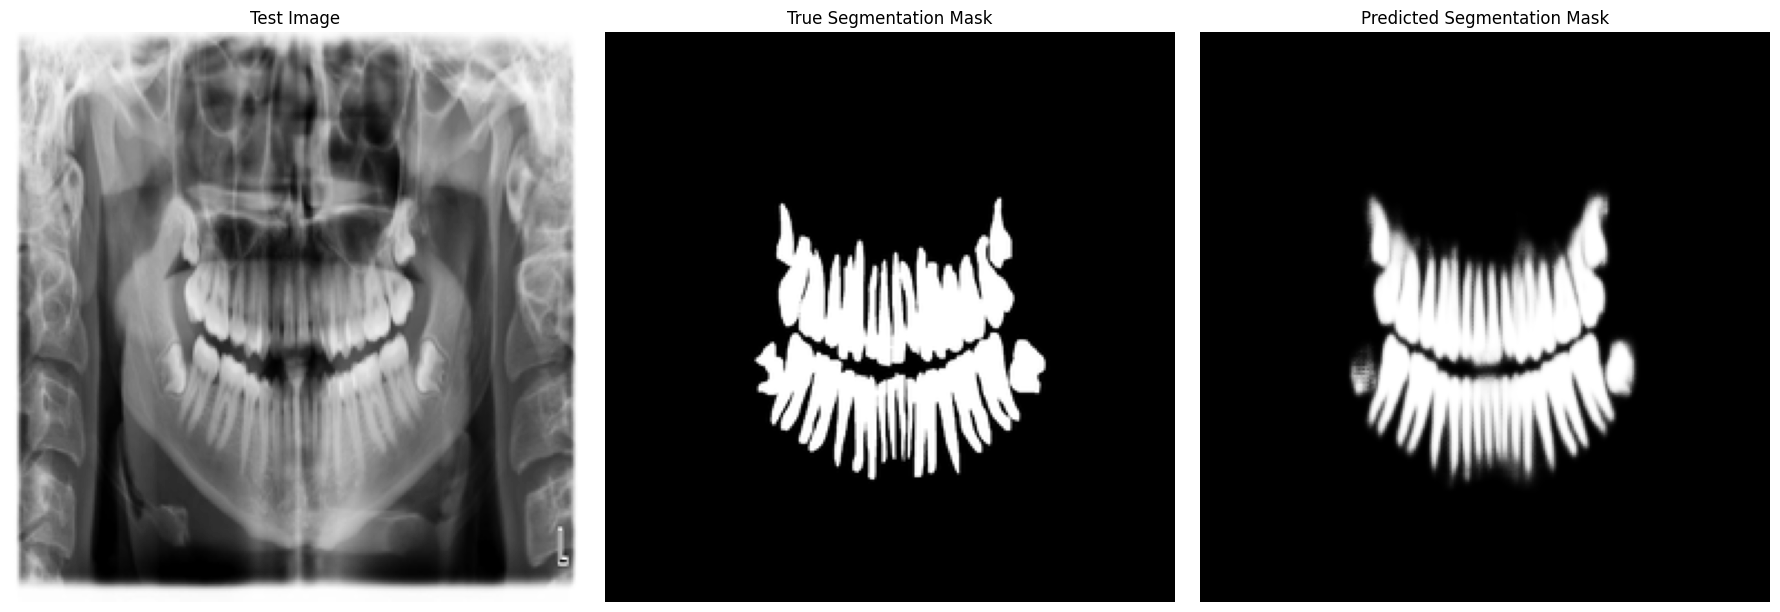

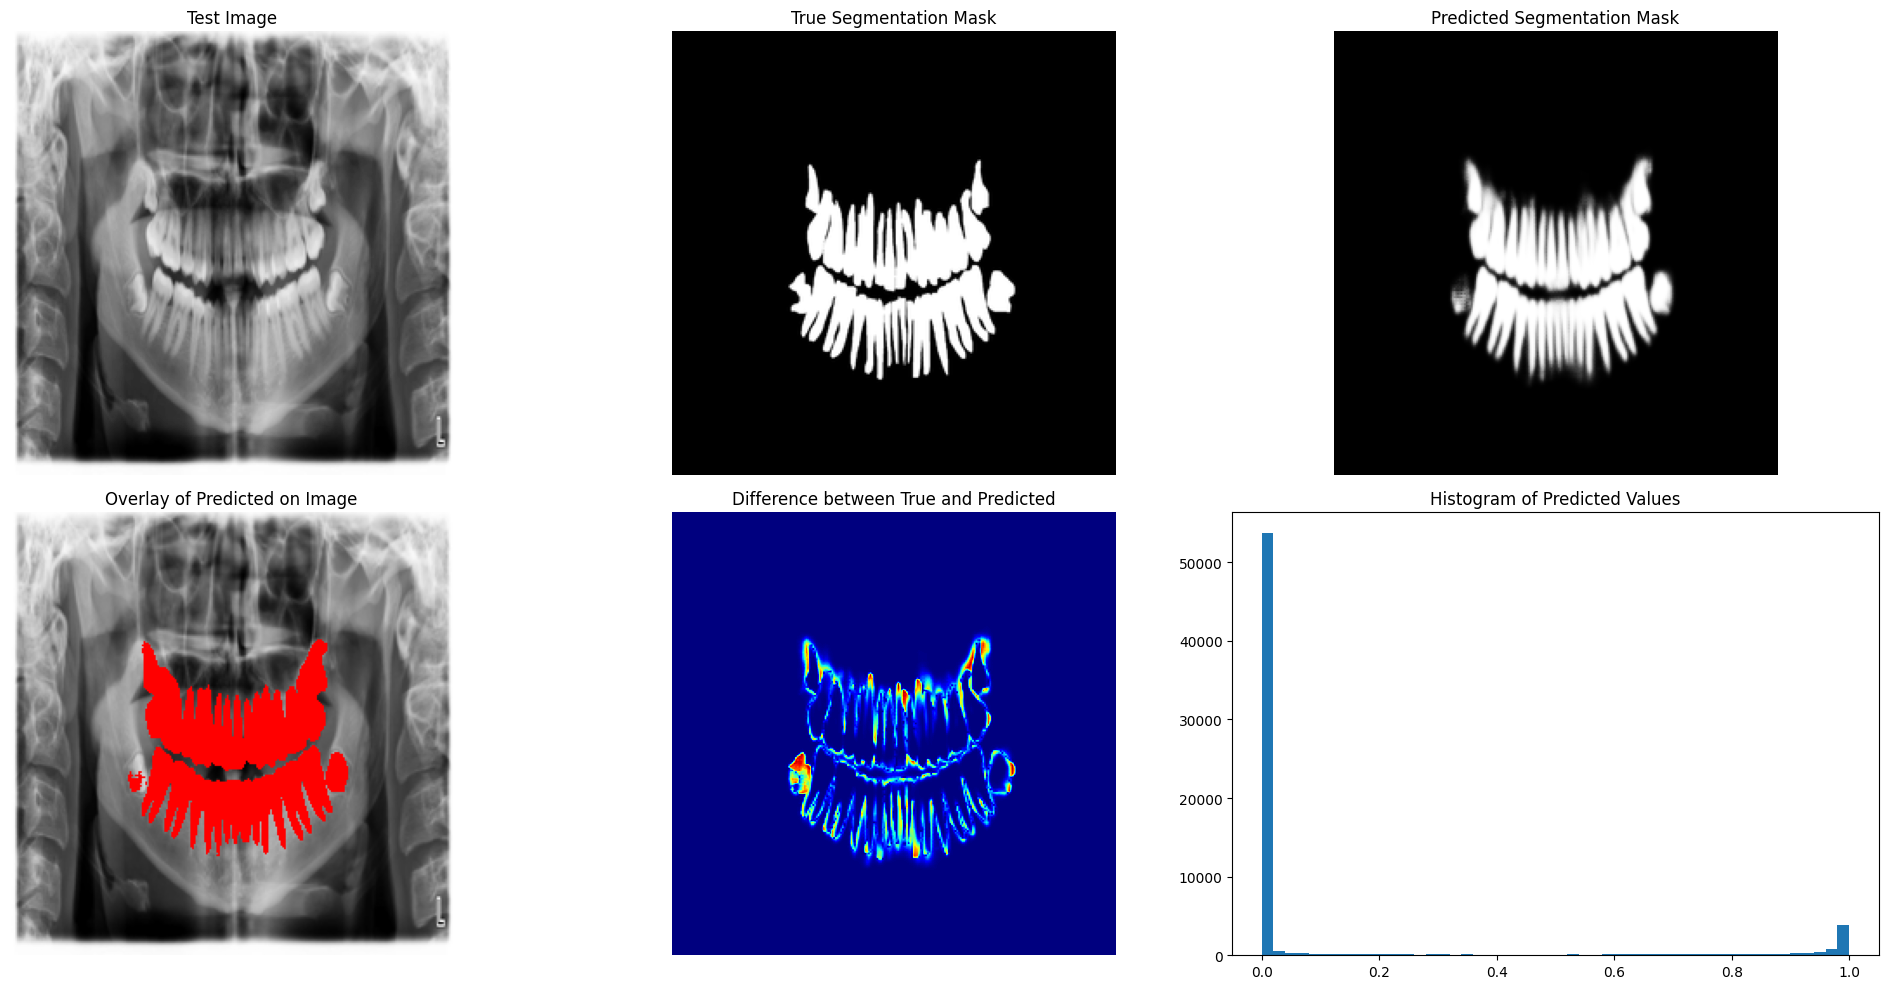

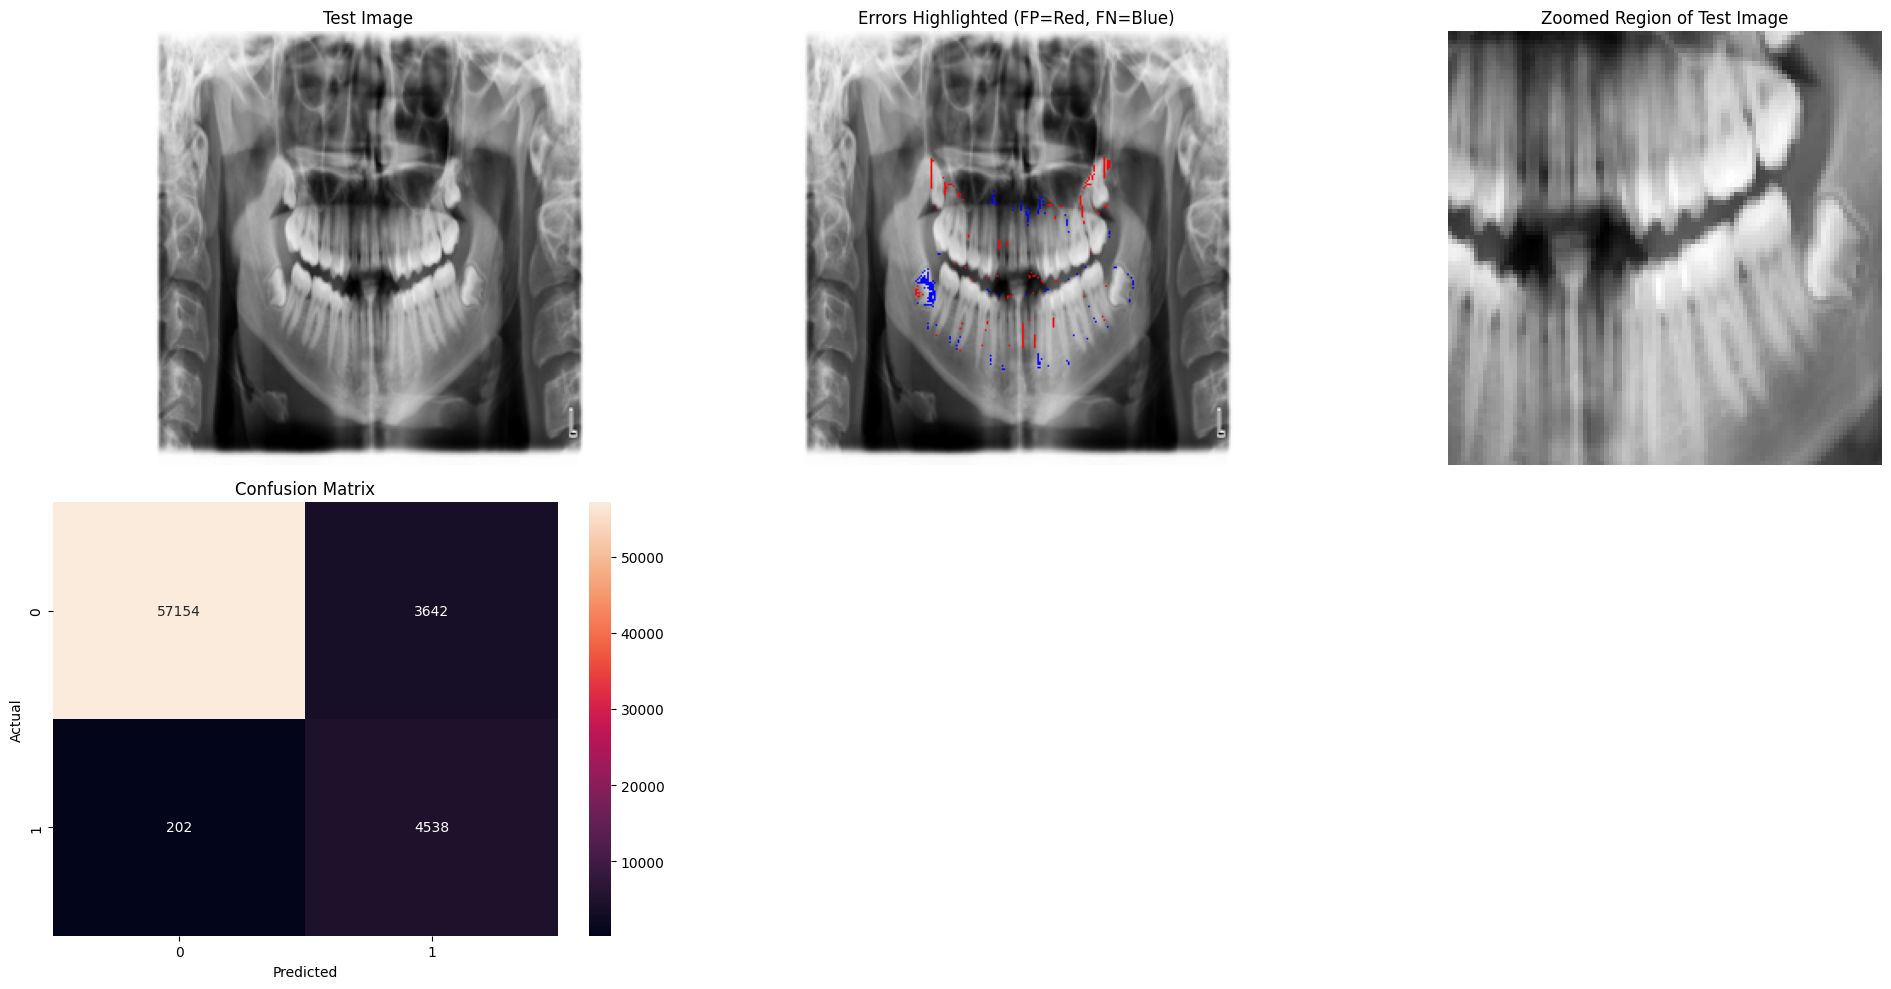

In [ ]:
visualizer = Visualization()
visualizer.visualize_images(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])
visualizer.detailed_visualization(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])
visualizer.advanced_visualization(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])

## **Attention ResUNet**

In [ ]:
modelManager = ModelManager()
unetModels = UNetModels()
model = unetModels.res_unet_with_attention(input_shape=(256,256,1),last_activation='sigmoid')
model,history = modelManager.train(model,
                           normalized_images_train,normalized_masks_train,
                           normalized_images_val,normalized_masks_val,epochs=100
                           )

modelManager.save_model(model,drive_path+"/models/res_unet_with_attention_256_epochs_100_"+str(len(images))+"_images.h5")
predicted_mask = modelManager.predict(model,normalized_images_test)
modelManager.evaluation_metrics(predicted_mask,normalized_masks_test)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 256, 256, 32)   │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 256, 256, 32)   │            128 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 256, 256, 32)   │             64 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 256, 256, 32)   │            128 │ conv2d_29[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 256, 256, 32)   │            128 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 256, 256, 32)   │              0 │ add_9[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 32)   │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 128, 128, 64)   │            256 │ conv2d_31[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 128, 128, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)   

 Total params: 8,393,249 (32.02 MB)

 Trainable params: 8,382,497 (31.98 MB)

 Non-trainable params: 10,752 (42.00 KB)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 146s 239ms/step - accuracy: 0.8625 - loss: 0.2356 - val_accuracy: 0.9056 - val_loss: 0.1066
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 105s 233ms/step - accuracy: 0.9029 - loss: 0.1166 - val_accuracy: 0.9106 - val_loss: 0.0870
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 87s 232ms/step - accuracy: 0.9067 - loss: 0.1032 - val_accuracy: 0.9167 - val_loss: 0.0727
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 140s 228ms/step - accuracy: 0.9096 - loss: 0.0959 - val_accuracy: 0.9144 - val_loss: 0.0772
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.9106 - loss: 0.0914 - val_accuracy: 0.9164 - val_loss: 0.0688
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 86s 229ms/step - accuracy: 0.9117 - loss: 0.0873 - val_accuracy: 0.9158 - val_loss: 0.0708
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 231ms/step - accuracy: 0.9126 - loss: 0.0846 - val_accuracy: 0.9143 - val_loss: 0.0784
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 228ms/step - accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 753ms/step
Evaluation Metrics:
Metric                   Value                    
F1 Score:                0.9077
Accuracy:                0.9753
Dice Score:              0.9077
Precision:               0.8681
Recall:                  0.9510
Jaccard Coefficient (IoU):0.8309
Intersection over Union (IoU):0.8309


## **UNET**

In [ ]:
modelManager = ModelManager()
unetModels = UNetModels()
model = unetModels.unet(input_shape=(256,256,1),last_activation='sigmoid')
model,history = modelManager.train(model,
                           normalized_images_train,normalized_masks_train,
                           normalized_images_val,normalized_masks_val,epochs=200
                           )

modelManager.save_model(model,drive_path+"/models/unet_256_epochs_200_"+str(len(images))+"_images.h5")
predicted_mask = modelManager.predict(model,normalized_images_test)
modelManager.evaluation_metrics(predicted_mask,normalized_masks_test)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 32)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)    

 Total params: 13,423,361 (51.21 MB)

 Trainable params: 13,420,481 (51.20 MB)

 Non-trainable params: 2,880 (11.25 KB)

Epoch 1/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 120ms/step - accuracy: 0.8492 - loss: 0.2533 - val_accuracy: 0.7983 - val_loss: 0.3377
Epoch 2/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.8990 - loss: 0.1341 - val_accuracy: 0.9095 - val_loss: 0.0991
Epoch 3/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 105ms/step - accuracy: 0.9039 - loss: 0.1145 - val_accuracy: 0.9136 - val_loss: 0.0835
Epoch 4/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.9077 - loss: 0.1018 - val_accuracy: 0.9134 - val_loss: 0.0801
Epoch 5/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - accuracy: 0.9074 - loss: 0.1010 - val_accuracy: 0.9150 - val_loss: 0.0780
Epoch 6/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.9101 - loss: 0.0942 - val_accuracy: 0.9154 - val_loss: 0.0755
Epoch 7/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.9097 - loss: 0.0924 - val_accuracy: 0.9168 - val_loss: 0.0708
Epoch 8/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.9116 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step
Evaluation Metrics:
Metric                   Value                    
F1 Score:                0.9161
Accuracy:                0.9778
Dice Score:              0.9161
Precision:               0.8880
Recall:                  0.9460
Jaccard Coefficient (IoU):0.8452
Intersection over Union (IoU):0.8452


In [ ]:
modelManager = ModelManager()
model = modelManager.load_model(drive_path+"/models/unet_256_epochs_200_"+str(len(images))+"_images.h5")
predicted_mask = modelManager.predict(model,normalized_images_test)
modelManager.evaluation_metrics(predicted_mask,normalized_masks_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
Evaluation Metrics:
Metric                   Value                    
F1 Score:                0.9161
Accuracy:                0.9778
Dice Score:              0.9161
Precision:               0.8880
Recall:                  0.9460
Jaccard Coefficient (IoU):0.8452
Intersection over Union (IoU):0.8452


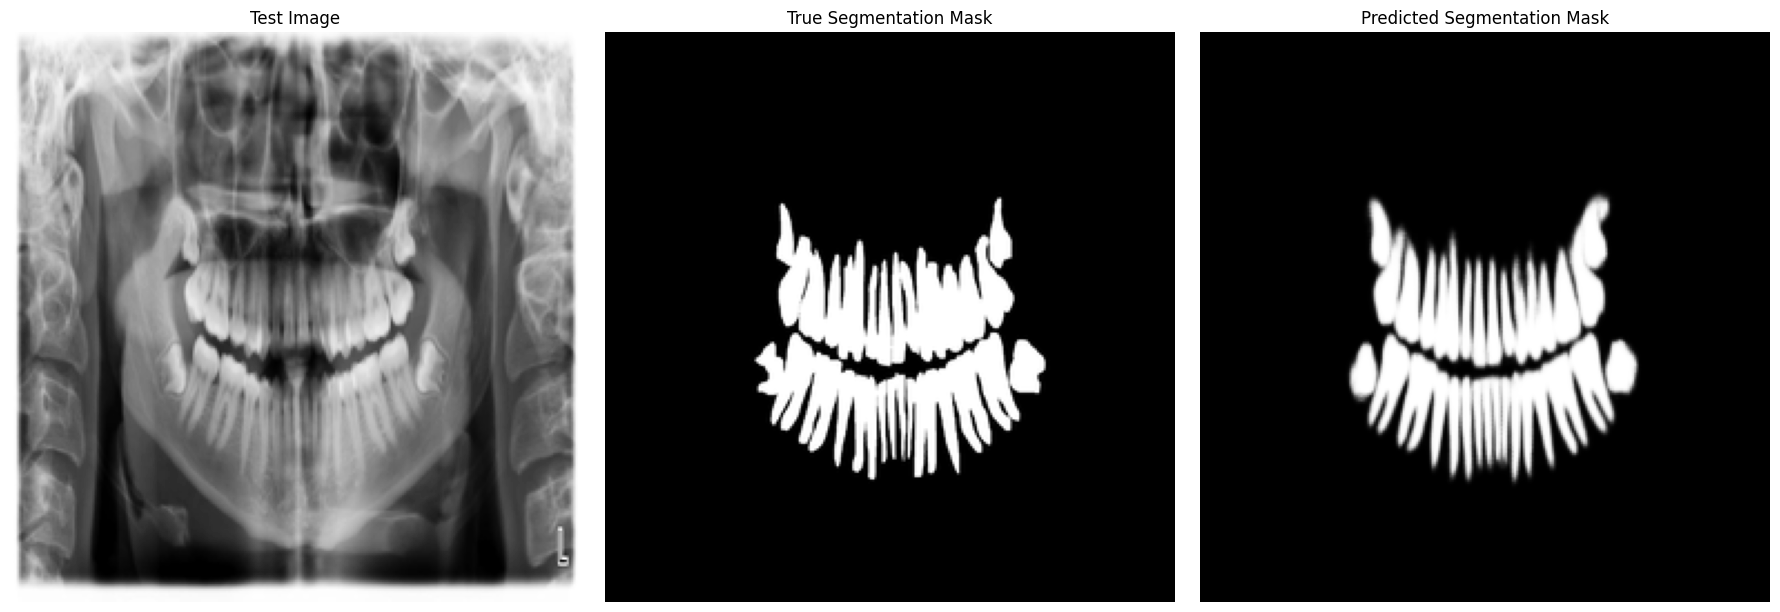

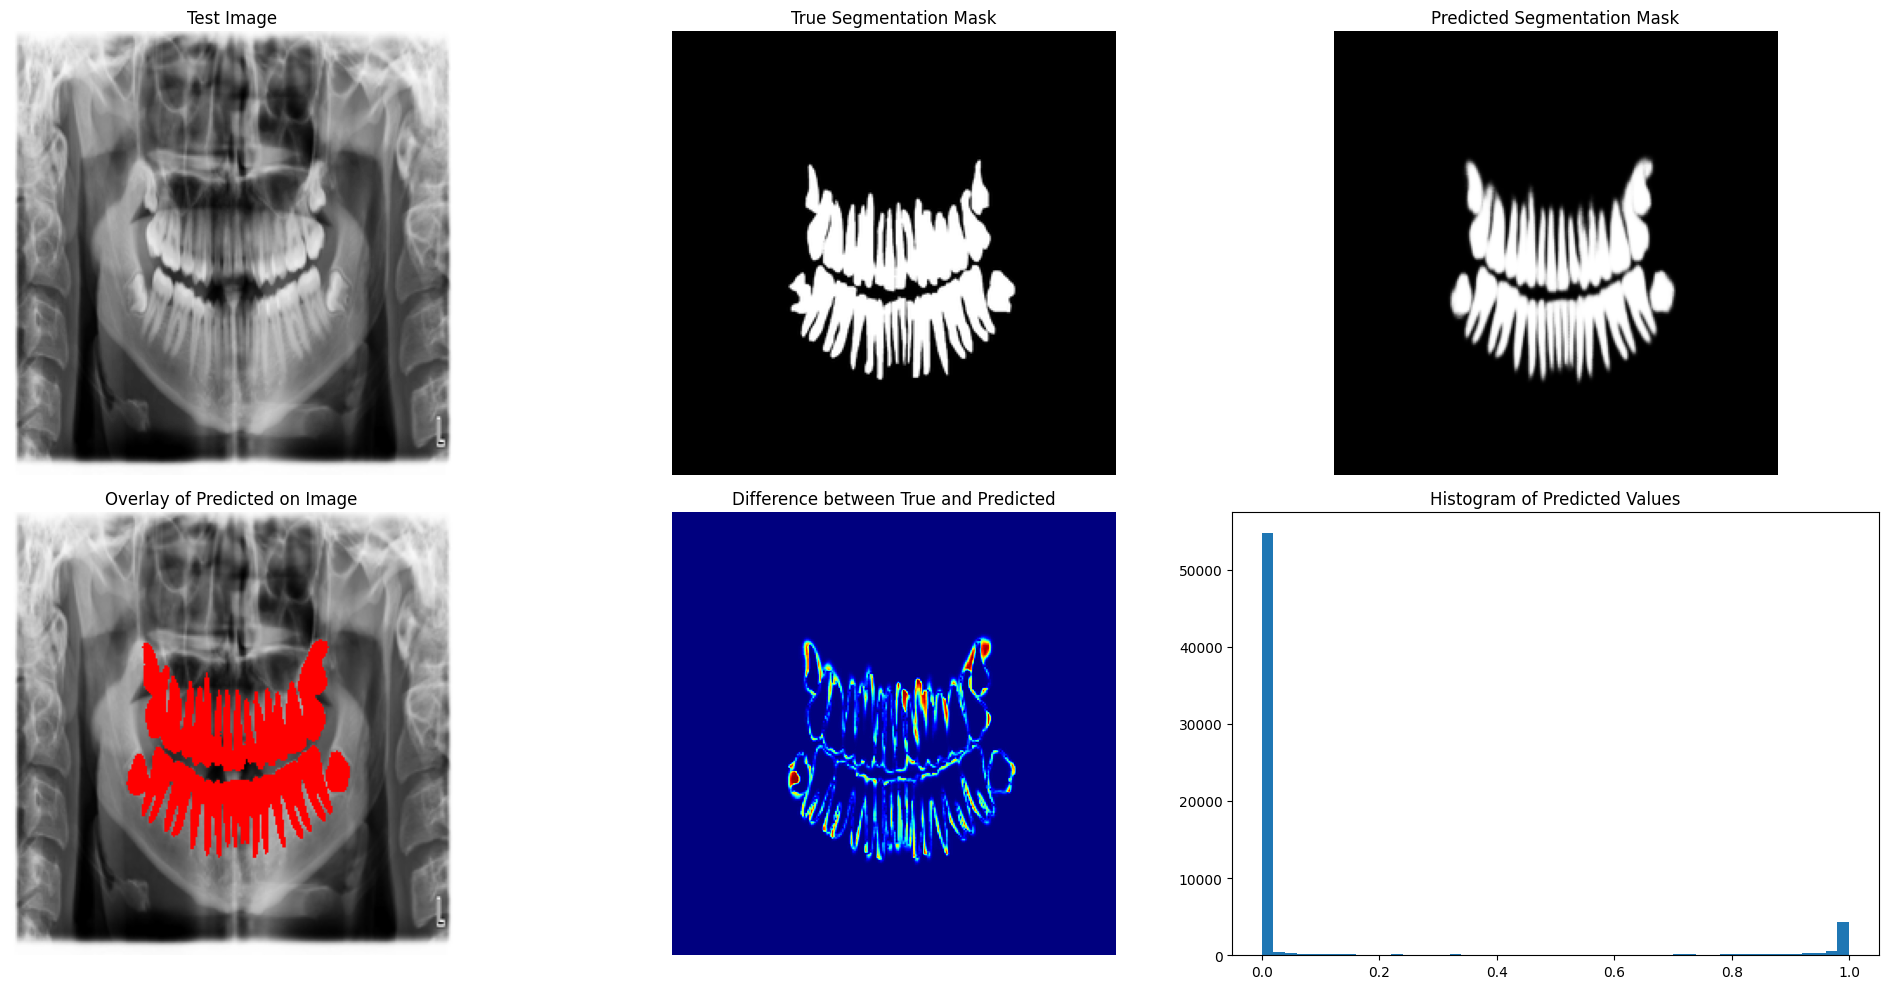

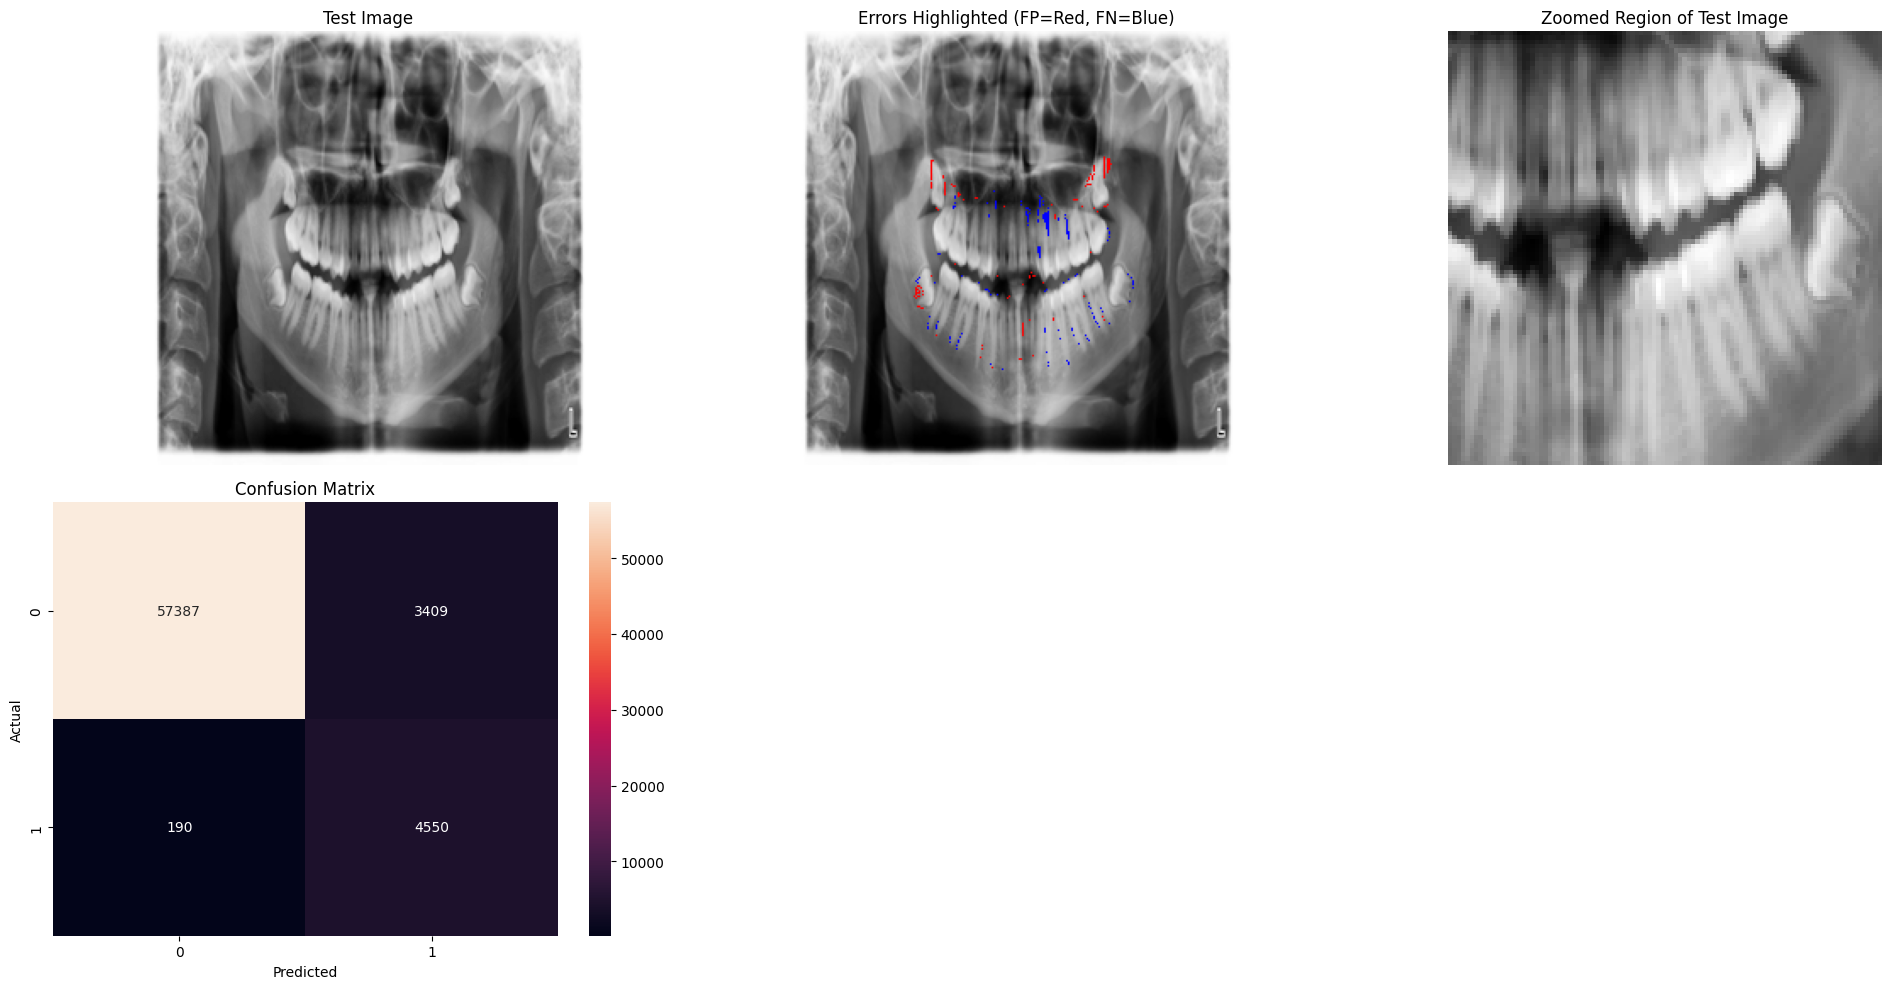

In [ ]:
visualizer = Visualization()
visualizer.visualize_images(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])
visualizer.detailed_visualization(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])
visualizer.advanced_visualization(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])

# **Trans Unet**

In [ ]:
modelManager = ModelManager()
unetModels = UNetModels()

# Build the Transfer UNet model
model = unetModels.transfer_unet(input_shape=(256, 256, 1), last_activation='sigmoid')

# Train the model
model, history = modelManager.train(model,
                                    normalized_images_train, normalized_masks_train,
                                    normalized_images_val, normalized_masks_val, epochs=100)

# Save the model
modelManager.save_model(model, drive_path + "/models/transfer_unet_256_epochs_100_" + str(len(images)) + "_images.h5")

# Predict using the trained model
predicted_mask = modelManager.predict(model, normalized_images_test)

# Evaluate the model
modelManager.evaluation_metrics(predicted_mask, normalized_masks_test)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Skipping layer conv2d_transpose
Skipping layer concatenate


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 3)    │              6 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)

 Total params: 25,862,343 (98.66 MB)

 Trainable params: 25,858,503 (98.64 MB)

 Non-trainable params: 3,840 (15.00 KB)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 123s 221ms/step - accuracy: 0.8459 - loss: 0.2923 - val_accuracy: 0.8655 - val_loss: 0.1980
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 211ms/step - accuracy: 0.8928 - loss: 0.1459 - val_accuracy: 0.8512 - val_loss: 0.2140
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 214ms/step - accuracy: 0.8999 - loss: 0.1249 - val_accuracy: 0.9139 - val_loss: 0.0856
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 215ms/step - accuracy: 0.9037 - loss: 0.1123 - val_accuracy: 0.9081 - val_loss: 0.0990
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 216ms/step - accuracy: 0.9053 - loss: 0.1060 - val_accuracy: 0.9147 - val_loss: 0.0813
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.9079 - loss: 0.1003 - val_accuracy: 0.9166 - val_loss: 0.0738
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.9093 - loss: 0.0972 - val_accuracy: 0.9177 - val_loss: 0.0679
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.9098 

7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step
Evaluation Metrics:
Metric                   Value                    
F1 Score:                0.9074
Accuracy:                0.9759
Dice Score:              0.9074
Precision:               0.8921
Recall:                  0.9232
Jaccard Coefficient (IoU):0.8305
Intersection over Union (IoU):0.8305


In [ ]:
modelManager = ModelManager()
model = modelManager.load_model(drive_path + "/models/transfer_unet_256_epochs_100_" + str(len(images)) + "_images.h5")
predicted_mask = modelManager.predict(model,normalized_images_test)
modelManager.evaluation_metrics(predicted_mask,normalized_masks_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step
Evaluation Metrics:
Metric                   Value                    
F1 Score:                0.9074
Accuracy:                0.9759
Dice Score:              0.9074
Precision:               0.8921
Recall:                  0.9232
Jaccard Coefficient (IoU):0.8304
Intersection over Union (IoU):0.8304


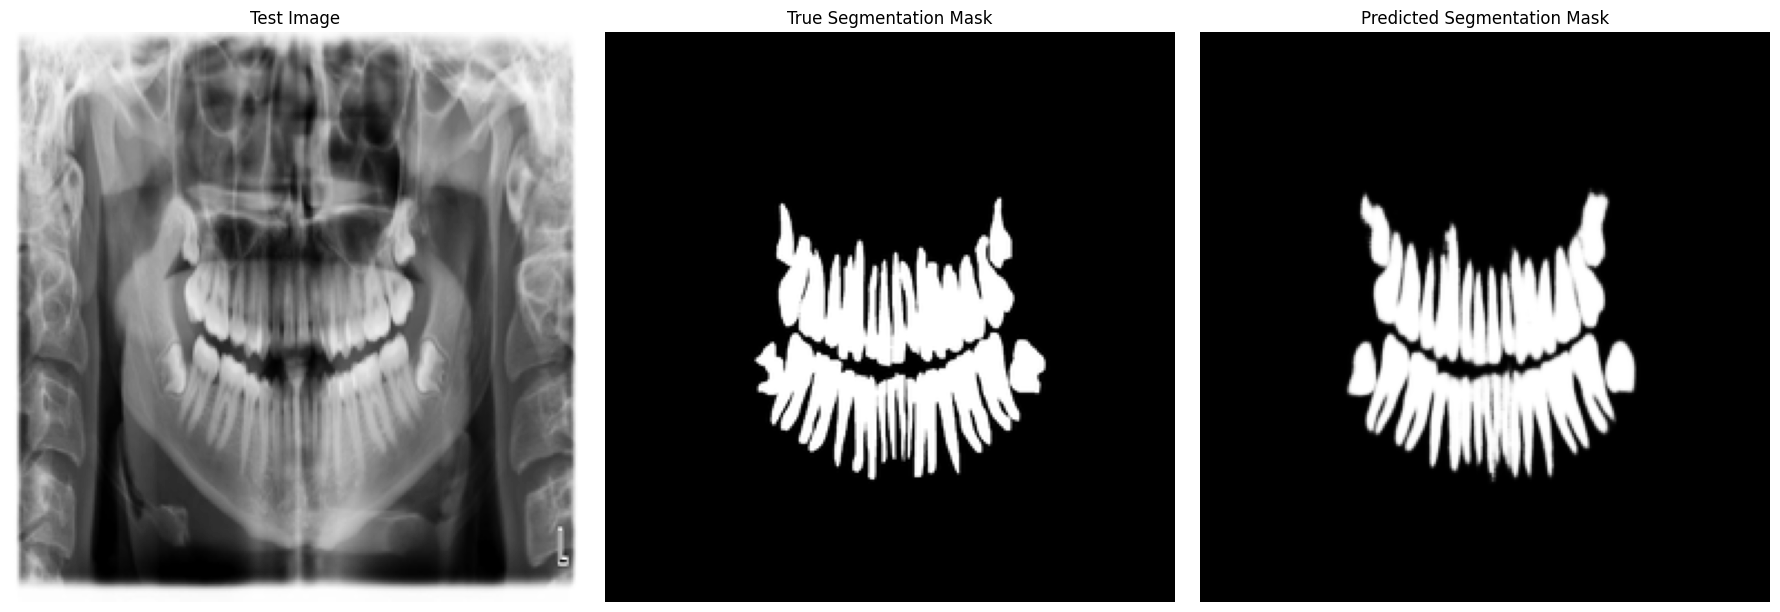

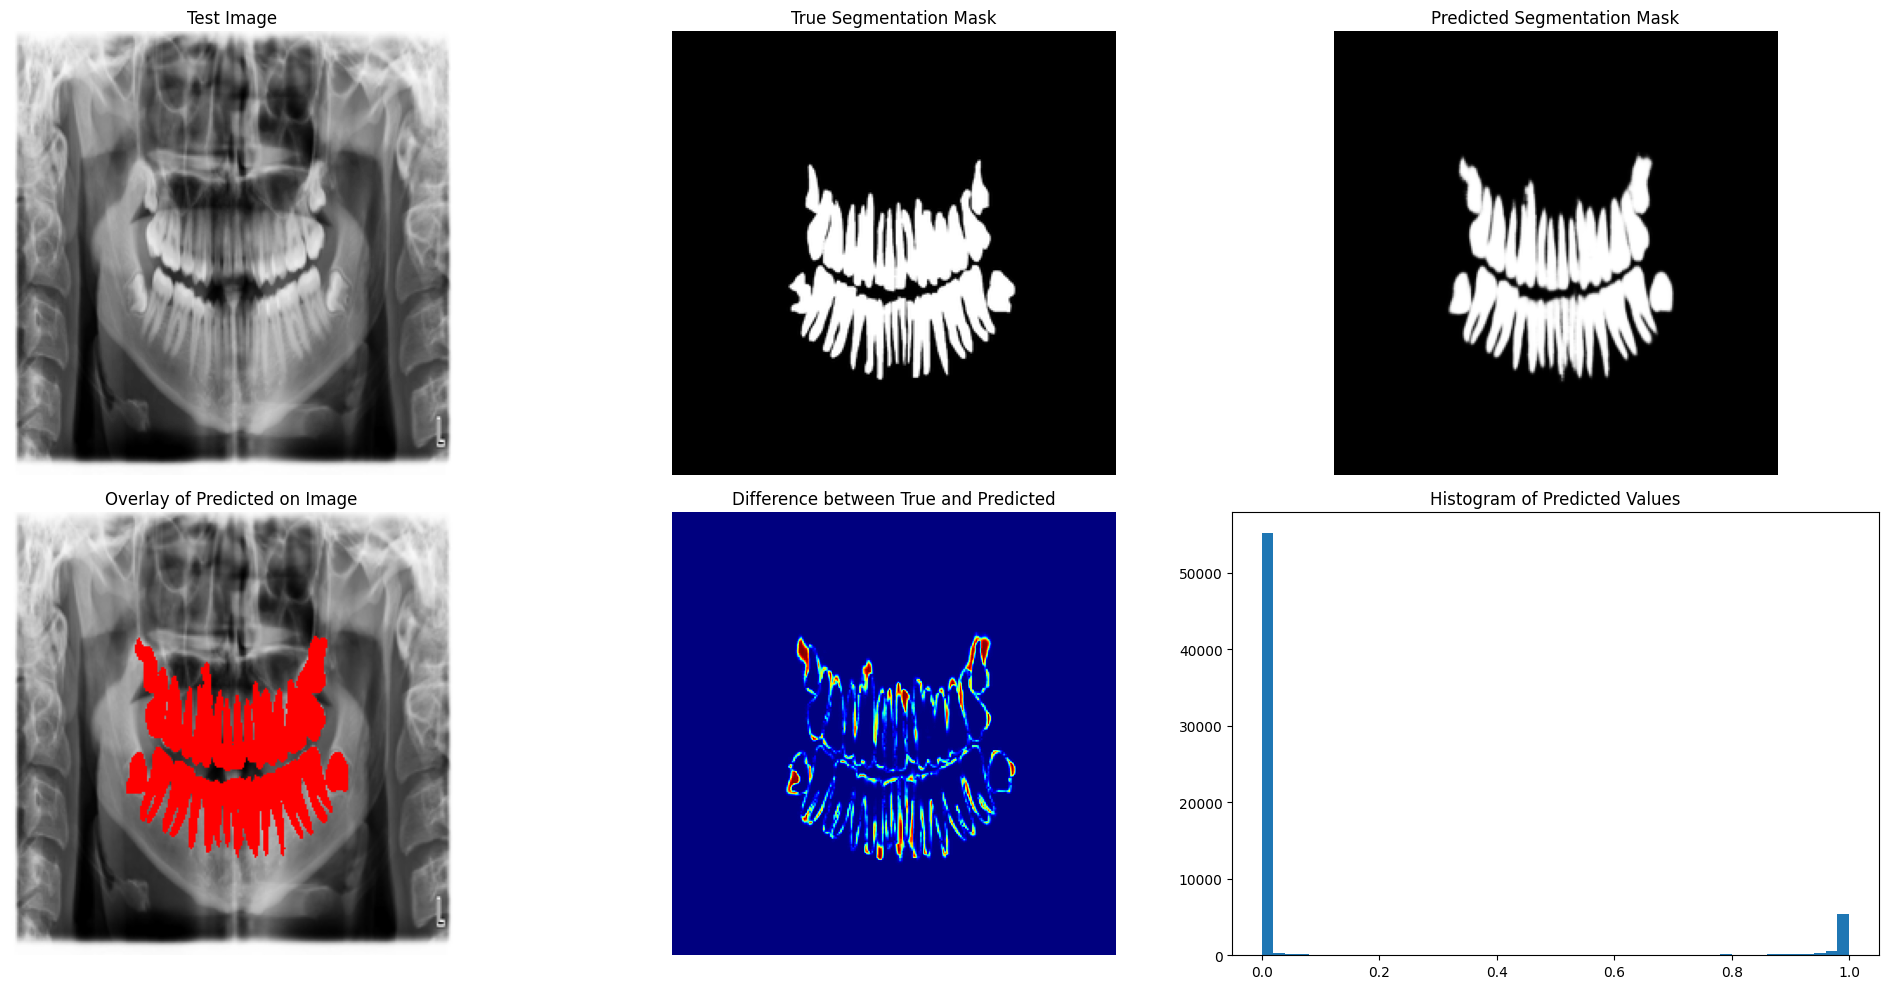

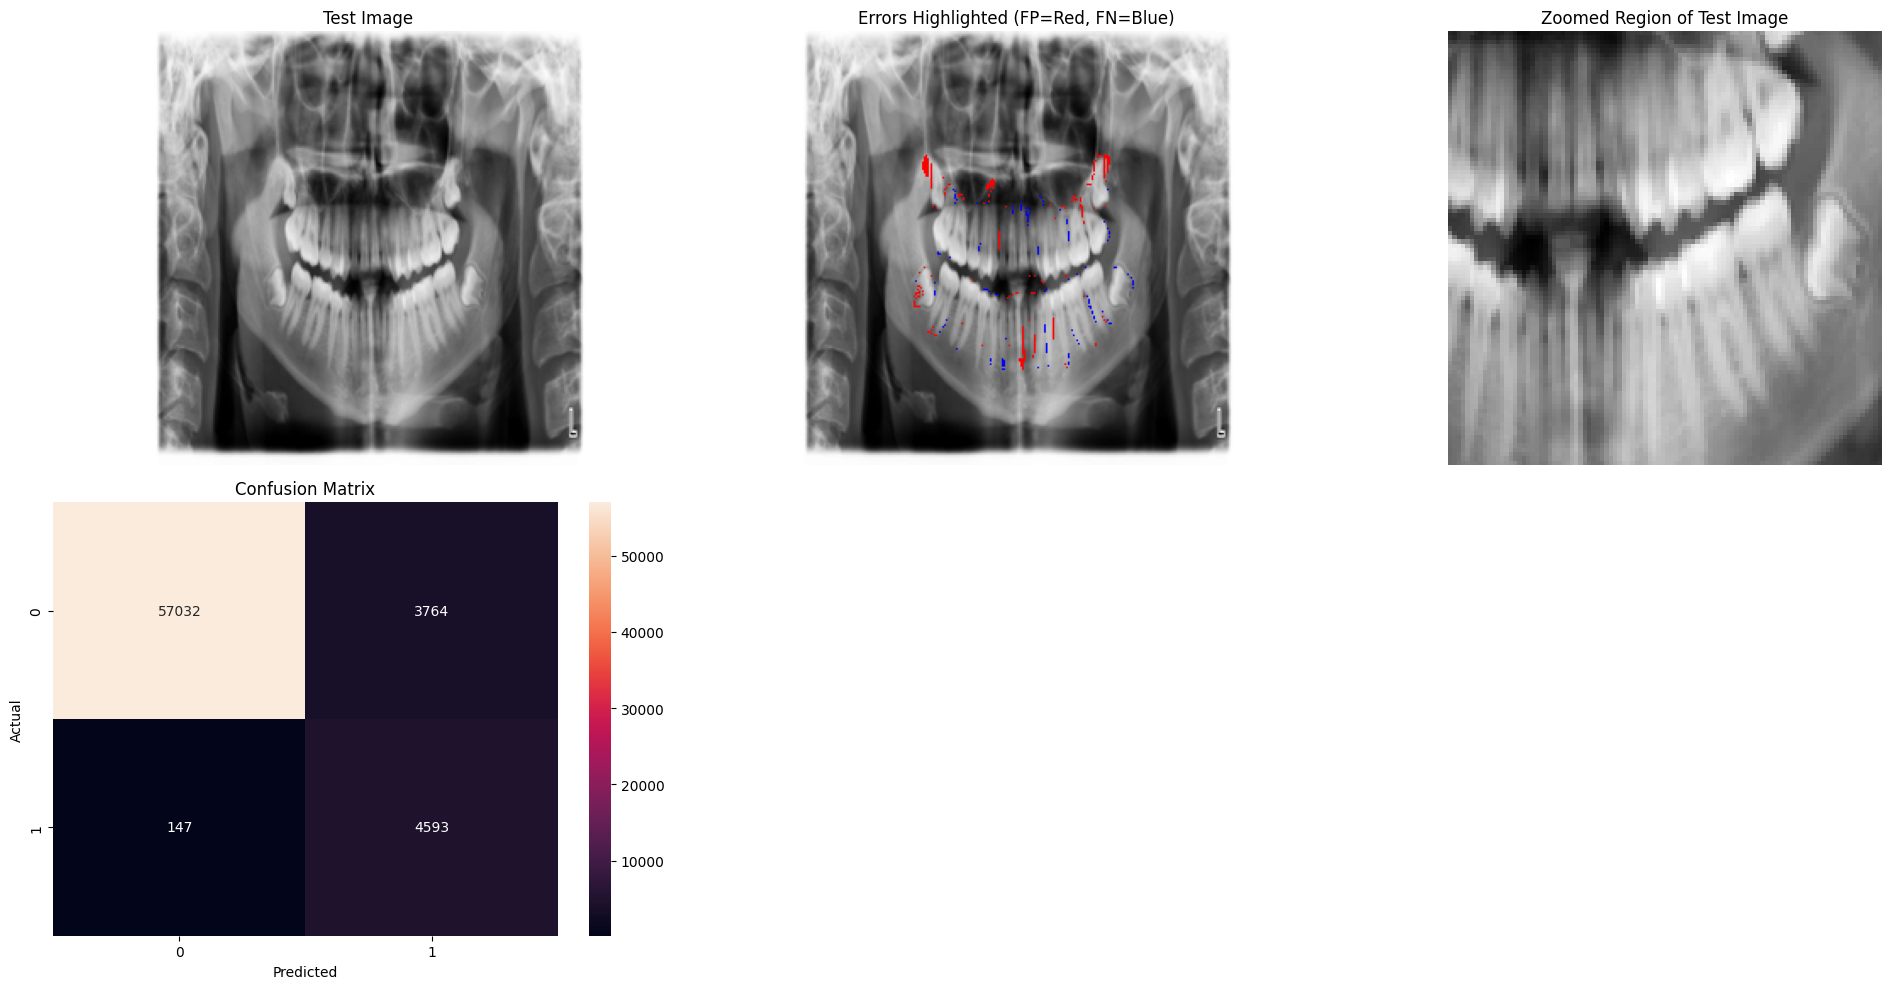

In [ ]:
visualizer = Visualization()
visualizer.visualize_images(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])
visualizer.detailed_visualization(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])
visualizer.advanced_visualization(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])

# **Vision Transformer**

In [ ]:
def create_vit_segmentation_model(input_shape=(256, 256, 1), num_classes=1, patch_size=16, projection_dim=64, num_heads=4, transformer_units=[128, 64], transformer_layers=8):
    inputs = layers.Input(shape=input_shape)

    # Create patches
    patches = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    patches = layers.Reshape((-1, projection_dim))(patches)

    # Add positional encoding
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(tf.range(num_patches))
    encoded_patches = patches + position_embedding

    # Transformer layers
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = layers.Dense(transformer_units[0], activation=tf.nn.gelu)(x3)
        x3 = layers.Dense(transformer_units[1], activation=tf.nn.gelu)(x3)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Reshape the encoded patches back to image size
    reshaped_patches = layers.Reshape((input_shape[0] // patch_size, input_shape[1] // patch_size, projection_dim))(encoded_patches)

    # Decoder to match the input size
    decoded_patches = layers.Conv2DTranspose(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(reshaped_patches)

    # Additional convolutional layers to ensure the output shape matches the input shape
    outputs = layers.Conv2D(filters=projection_dim, kernel_size=(3, 3), padding='same', activation='relu')(decoded_patches)
    outputs = layers.Conv2D(filters=projection_dim, kernel_size=(3, 3), padding='same', activation='relu')(outputs)
    outputs = layers.Conv2D(filters=num_classes, kernel_size=(3, 3), padding='same', activation='sigmoid')(outputs)

    return Model(inputs, outputs)

# Define model parameters
input_shape = (256, 256, 1)
num_classes = 1

# Create the model
vit_model = create_vit_segmentation_model(input_shape=input_shape, num_classes=num_classes)

# Compile the model
vit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
vit_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         16,448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 256, 64)        │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 64)        │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 256, 64)        │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 256, 64)        │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 64)        │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 256, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256, 128)       │          8,320 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256, 64)        │          8,256 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 64)        │              0 │ dense_7[0][0],         │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 256, 64)        │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 256, 64)        │         66,368 │ layer_normalization_4… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 256, 64)        │            128 │ add_3[0][0]            │
│ (LayerNormalization) 

 Total params: 1,805,121 (6.89 MB)

 Trainable params: 1,805,121 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Initialize ModelManager and ViT model
modelManager = ModelManager()

# Define the ViT model
vit_model = create_vit_segmentation_model(input_shape=(256,256,1), num_classes=1)

# Train the ViT model
vit_model, history = modelManager.train(vit_model,
                           normalized_images_train, normalized_masks_train,
                           normalized_images_val, normalized_masks_val, epochs=100
                           )

# Save the trained ViT model
modelManager.save_model(vit_model, drive_path + "/models/vit_256_epochs_100_" + str(len(images)) + "_images.h5")

# Predict using the trained ViT model
predicted_mask = modelManager.predict(vit_model, normalized_images_test)

# Evaluate the ViT model
modelManager.evaluation_metrics(predicted_mask, normalized_masks_test)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 64)     │         16,448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 256, 64)        │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 256, 64)        │              0 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_16    │ (None, 256, 64)        │            128 │ add_17[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_8    │ (None, 256, 64)        │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 256, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ add_17[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_17    │ (None, 256, 64)        │            128 │ add_18[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 256, 128)       │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 256, 64)        │          8,256 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)              │ (None, 256, 64)        │              0 │ dense_17[0][0],        │
│                           │                        │                │ add_18[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_18    │ (None, 256, 64)        │            128 │ add_19[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_9    │ (None, 256, 64)        │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_20 (Add)              │ (None, 256, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ add_19[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_19    │ (None, 256, 64)        │            128 │ add_20[0][0]           │
│ (LayerNormalization) 

 Total params: 1,805,121 (6.89 MB)

 Trainable params: 1,805,121 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 105ms/step - accuracy: 0.8536 - loss: 0.3246 - val_accuracy: 0.8572 - val_loss: 0.3216
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - accuracy: 0.8553 - loss: 0.2982 - val_accuracy: 0.8572 - val_loss: 0.3203
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - accuracy: 0.8550 - loss: 0.2874 - val_accuracy: 0.8576 - val_loss: 0.2823
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.8566 - loss: 0.2750 - val_accuracy: 0.8603 - val_loss: 0.2756
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.8579 - loss: 0.2640 - val_accuracy: 0.8618 - val_loss: 0.2642
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - accuracy: 0.8585 - loss: 0.2587 - val_accuracy: 0.8654 - val_loss: 0.2521
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.8604 - loss: 0.2527 - val_accuracy: 0.8658 - val_loss: 0.2462
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.8631 - loss: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 673ms/step
Evaluation Metrics:
Metric                   Value                    
F1 Score:                0.9211
Accuracy:                0.9211
Dice Score:              0.7980
Precision:               0.6577
Recall:                  0.7980
Jaccard Coefficient (IoU):0.5638
Intersection over Union (IoU):0.5638


# **Semi Supervised Learning**

In [ ]:
processor = PreprocessDataset()
modelManager = ModelManager()
# Loading unlabeled images
# unlabeled_images_path = "/content/drive/MyDrive/DentexSegAndDet/dentex_dataset/origin/unlabelled/xrays/"
unlabeled_images_path = "/content/drive/MyDrive/DentexSegAndDet/dentex_dataset/origin/quadrant_enumeration_disease/xrays/"
unlabeled_images,unlabeled_images_sizes=processor.load_images((256,256),unlabeled_images_path)

unlabeled_images = unlabeled_images
unlabeled_images_sizes = unlabeled_images_sizes

<ipython-input-4-3dbeef6385b7>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((resize_shape), Image.ANTIALIAS)


In [ ]:
normalized_unlabeled_images = processor.normalize_images(unlabeled_images)

In [ ]:
model_path = drive_path+"/models/resunet_256_epochs_100_1000_images.h5"
model = modelManager.load_model(model_path)

In [ ]:
modelManager = ModelManager()

In [ ]:
unlabeled_masks = modelManager.perform_semi_supervised_learning(model,normalized_unlabeled_images)

45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step


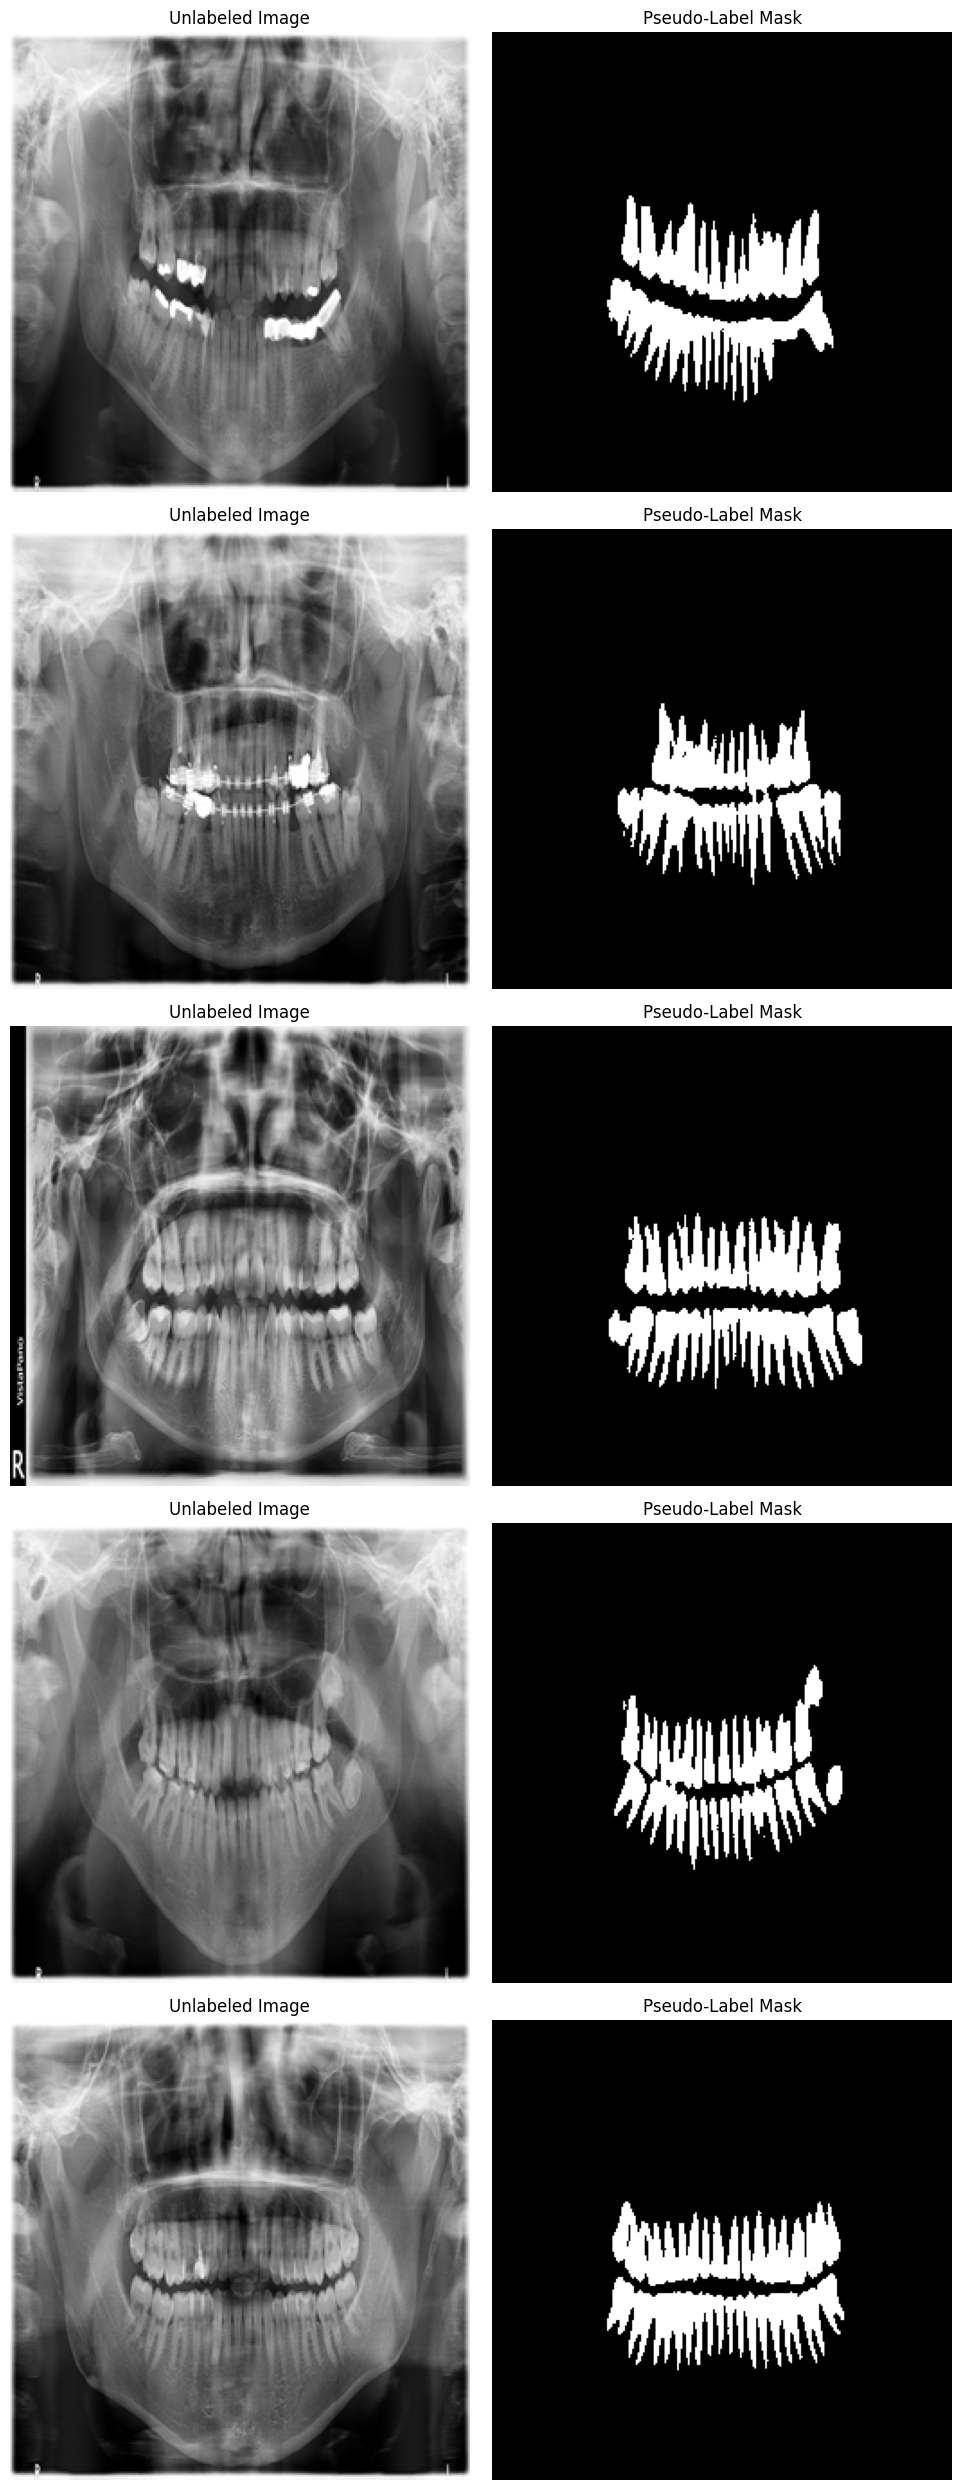

In [ ]:
import matplotlib.pyplot as plt

def plot_images_with_masks(images, masks, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

    for i in range(num_images):
        ax_img = axes[i, 0]
        ax_mask = axes[i, 1]

        ax_img.imshow(images[i].squeeze(), cmap='gray')
        ax_img.set_title('Unlabeled Image')
        ax_img.axis('off')

        ax_mask.imshow(masks[i].squeeze(), cmap='gray')
        ax_mask.set_title('Pseudo-Label Mask')
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()

# Plot the first 5 images and their corresponding pseudo-label masks
plot_images_with_masks(normalized_unlabeled_images, unlabeled_masks, num_images=5)


In [ ]:
# Combine images and masks
images = np.concatenate((images, unlabeled_images), axis=0)
normalized_masks = processor.normalize_images(masks)
normalized_masks = np.concatenate((normalized_masks, unlabeled_masks), axis=0)

In [ ]:
del normalized_unlabeled_images
del unlabeled_images
del unlabeled_masks

In [ ]:
# Retrain the selected model
normalized_images = processor.normalize_images(images)

x_normalized_images, normalized_images_test, y_normalized_masks, normalized_masks_test = train_test_split(normalized_images, normalized_masks , test_size=0.2, random_state=42)
normalized_images_train, normalized_images_val, normalized_masks_train, normalized_masks_val = train_test_split(x_normalized_images, y_normalized_masks, test_size=0.25, random_state=42)

In [ ]:
print(f"Training data: {len(normalized_images_train)} images")
print(f"Validation data: {len(normalized_images_val)} images")
print(f"Test data: {len(normalized_images_test)} images")

Training data: 1023 images
Validation data: 341 images
Test data: 341 images


In [ ]:
del images
del masks

In [ ]:
normalized_images_train, normalized_masks_train = processor.augment_data(normalized_images_train,normalized_masks_train)

In [ ]:
modelManager = ModelManager()
unetModels = UNetModels()
model = unetModels.res_unet(input_shape=(256,256,1),last_activation='sigmoid')
model,history = modelManager.train(model,
                           normalized_images_train,normalized_masks_train,
                           normalized_images_val,normalized_masks_val,epochs=100
                           )

modelManager.save_model(model,drive_path+"/models/resunet_256_epochs_100_700_images.h5")
predicted_mask = modelManager.predict(model,normalized_images_test)
modelManager.evaluation_metrics(predicted_mask,normalized_masks_test)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 32)   │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 32)   │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 32)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │          2,112 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 8,126,849 (31.00 MB)

 Trainable params: 8,118,017 (30.97 MB)

 Non-trainable params: 8,832 (34.50 KB)

Epoch 1/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 126s 134ms/step - accuracy: 0.8969 - loss: 0.1942 - val_accuracy: 0.9376 - val_loss: 0.0818
Epoch 2/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 62s 97ms/step - accuracy: 0.9256 - loss: 0.1057 - val_accuracy: 0.9400 - val_loss: 0.0758
Epoch 3/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 61s 96ms/step - accuracy: 0.9303 - loss: 0.0956 - val_accuracy: 0.9403 - val_loss: 0.0704
Epoch 4/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.9330 - loss: 0.0872 - val_accuracy: 0.9415 - val_loss: 0.0733
Epoch 5/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.9341 - loss: 0.0855 - val_accuracy: 0.9428 - val_loss: 0.0626
Epoch 6/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.9346 - loss: 0.0817 - val_accuracy: 0.9429 - val_loss: 0.0605
Epoch 7/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.9365 - loss: 0.0780 - val_accuracy: 0.9455 - val_loss: 0.0550
Epoch 8/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 61s 96ms/step - accuracy: 0.9367 - loss:

11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 932ms/step
Evaluation Metrics:
Metric                   Value                    
F1 Score:                0.9110
Accuracy:                0.9789
Dice Score:              0.9110
Precision:               0.8830
Recall:                  0.9408
Jaccard Coefficient (IoU):0.8366
Intersection over Union (IoU):0.8366


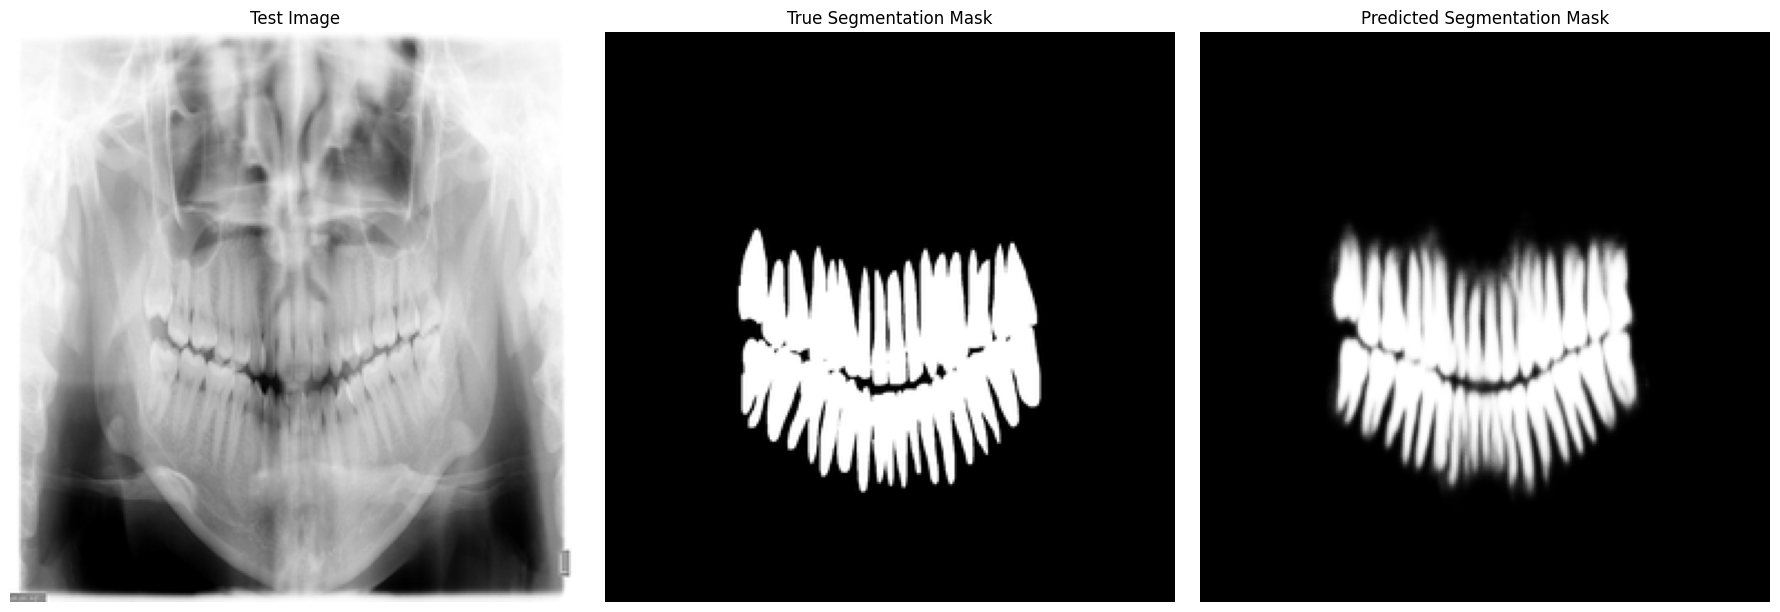

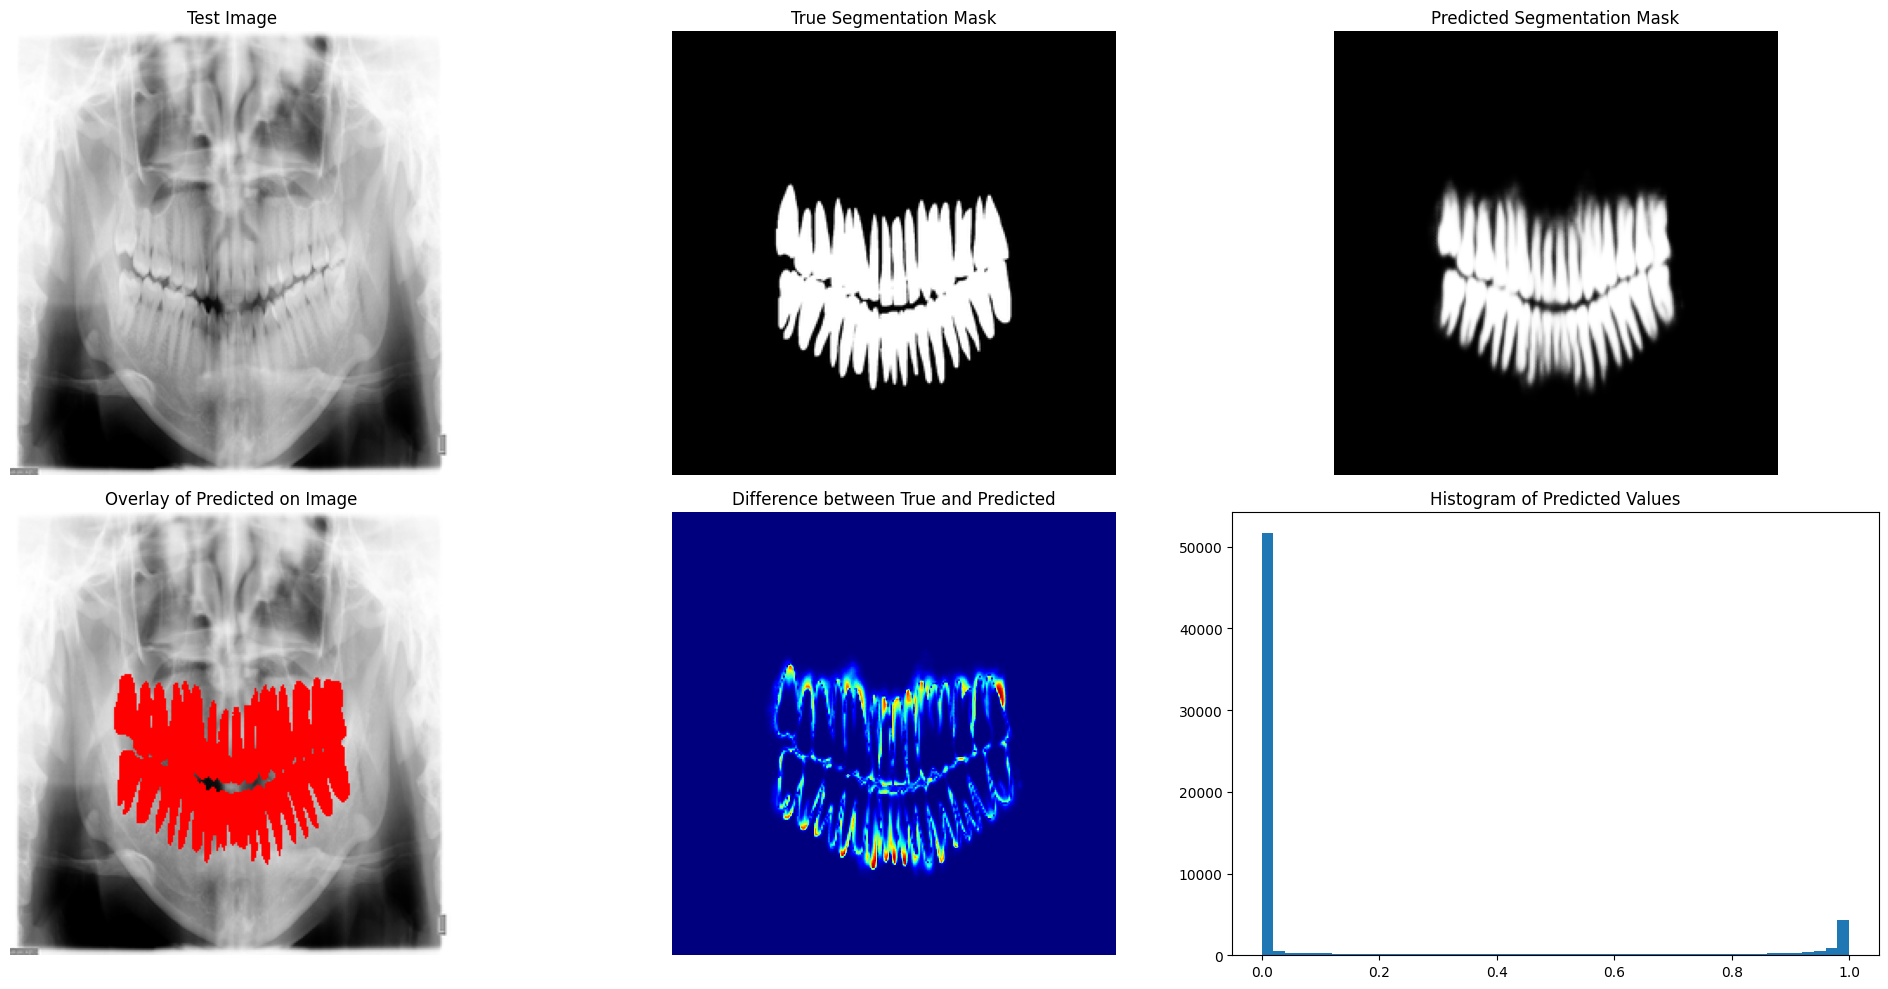

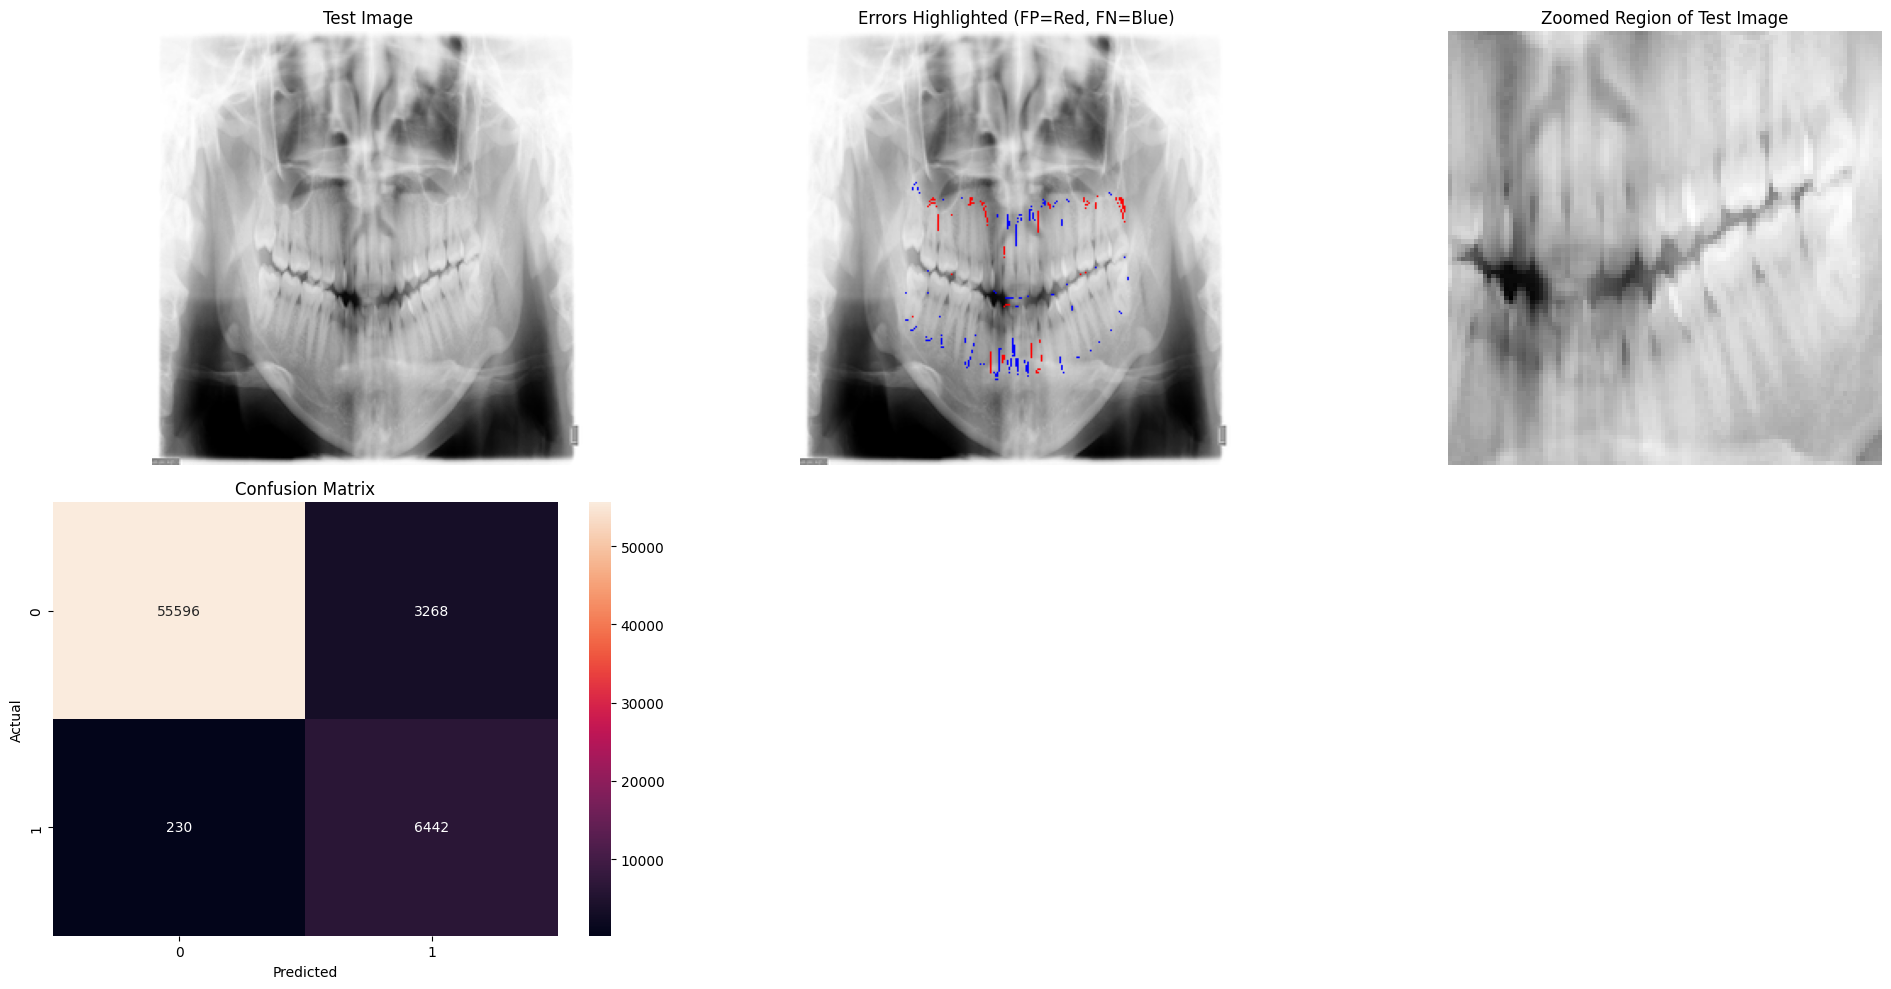

In [ ]:
visualizer = Visualization()
visualizer.visualize_images(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])
visualizer.detailed_visualization(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])
visualizer.advanced_visualization(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])

In [ ]:
modelManager = ModelManager()
unetModels = UNetModels()
model = unetModels.res_unet_with_attention(input_shape=(256,256,1),last_activation='sigmoid')
model,history = modelManager.train(model,
                           normalized_images_train,normalized_masks_train,
                           normalized_images_val,normalized_masks_val,epochs=100
                           )
predicted_mask = modelManager.predict(model,normalized_images_test)
modelManager.evaluation_metrics(predicted_mask,normalized_masks_test)
modelManager.save_model(model,drive_path+"/models/res_unet_with_attention_256_epochs_100_2571_images.keras")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 256, 256, 32)   │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 256, 256, 32)   │            128 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 256, 256, 32)   │             64 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 256, 256, 32)   │            128 │ conv2d_29[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 256, 256, 32)   │            128 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 256, 256, 32)   │              0 │ add_9[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 32)   │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 128, 128, 64)   │            256 │ conv2d_31[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 128, 128, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)   

 Total params: 8,393,249 (32.02 MB)

 Trainable params: 8,382,497 (31.98 MB)

 Non-trainable params: 10,752 (42.00 KB)

Epoch 1/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 177s 142ms/step - accuracy: 0.8877 - loss: 0.2687 - val_accuracy: 0.9494 - val_loss: 0.0797
Epoch 2/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 116s 120ms/step - accuracy: 0.9387 - loss: 0.1013 - val_accuracy: 0.9414 - val_loss: 0.0854
Epoch 3/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 115s 120ms/step - accuracy: 0.9419 - loss: 0.0906 - val_accuracy: 0.8434 - val_loss: 0.2672
Epoch 4/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 115s 119ms/step - accuracy: 0.9429 - loss: 0.0867 - val_accuracy: 0.9481 - val_loss: 0.0703
Epoch 5/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 115s 120ms/step - accuracy: 0.9446 - loss: 0.0818 - val_accuracy: 0.9567 - val_loss: 0.0546
Epoch 6/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 115s 120ms/step - accuracy: 0.9456 - loss: 0.0790 - val_accuracy: 0.9566 - val_loss: 0.0548
Epoch 7/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 115s 120ms/step - accuracy: 0.9471 - loss: 0.0769 - val_accuracy: 0.9576 - val_loss: 0.0527
Epoch 8/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 115s 119ms/step - accuracy: 

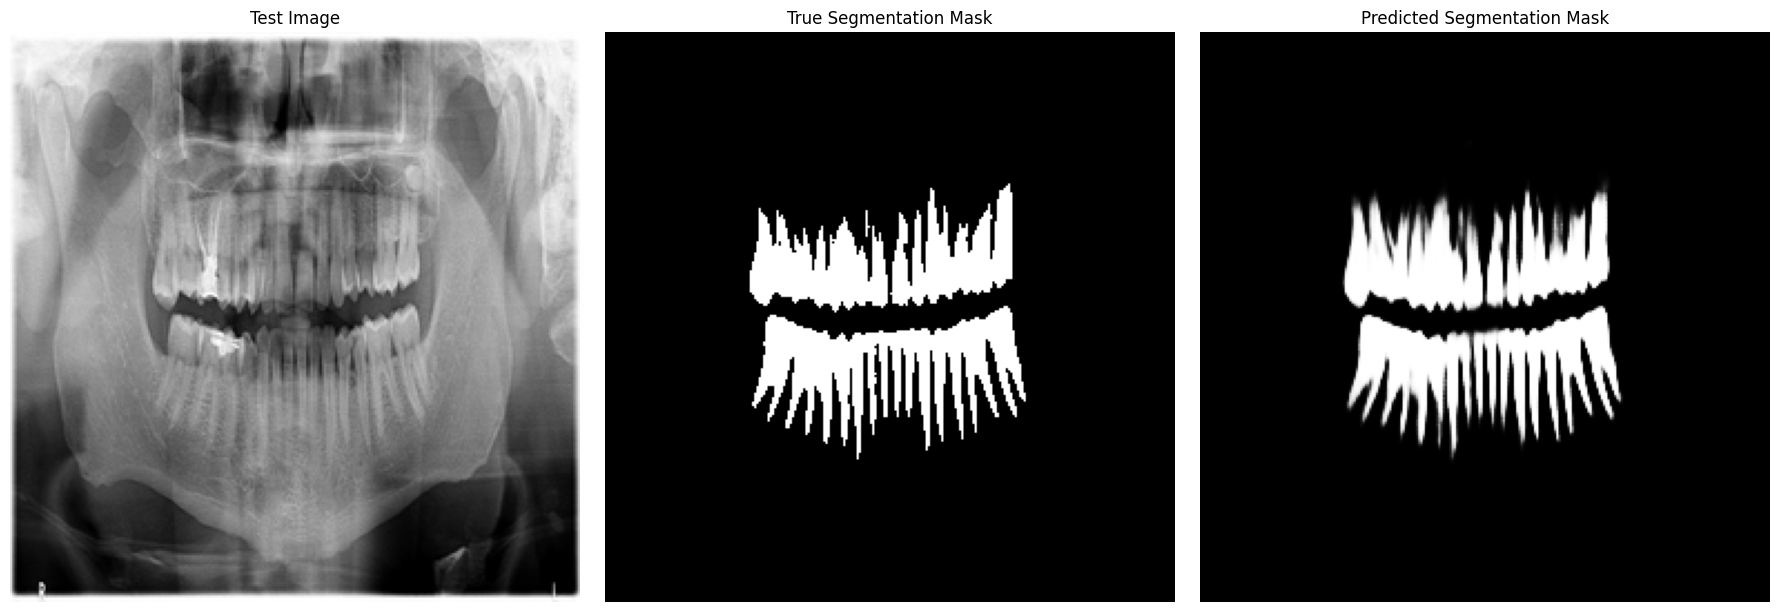

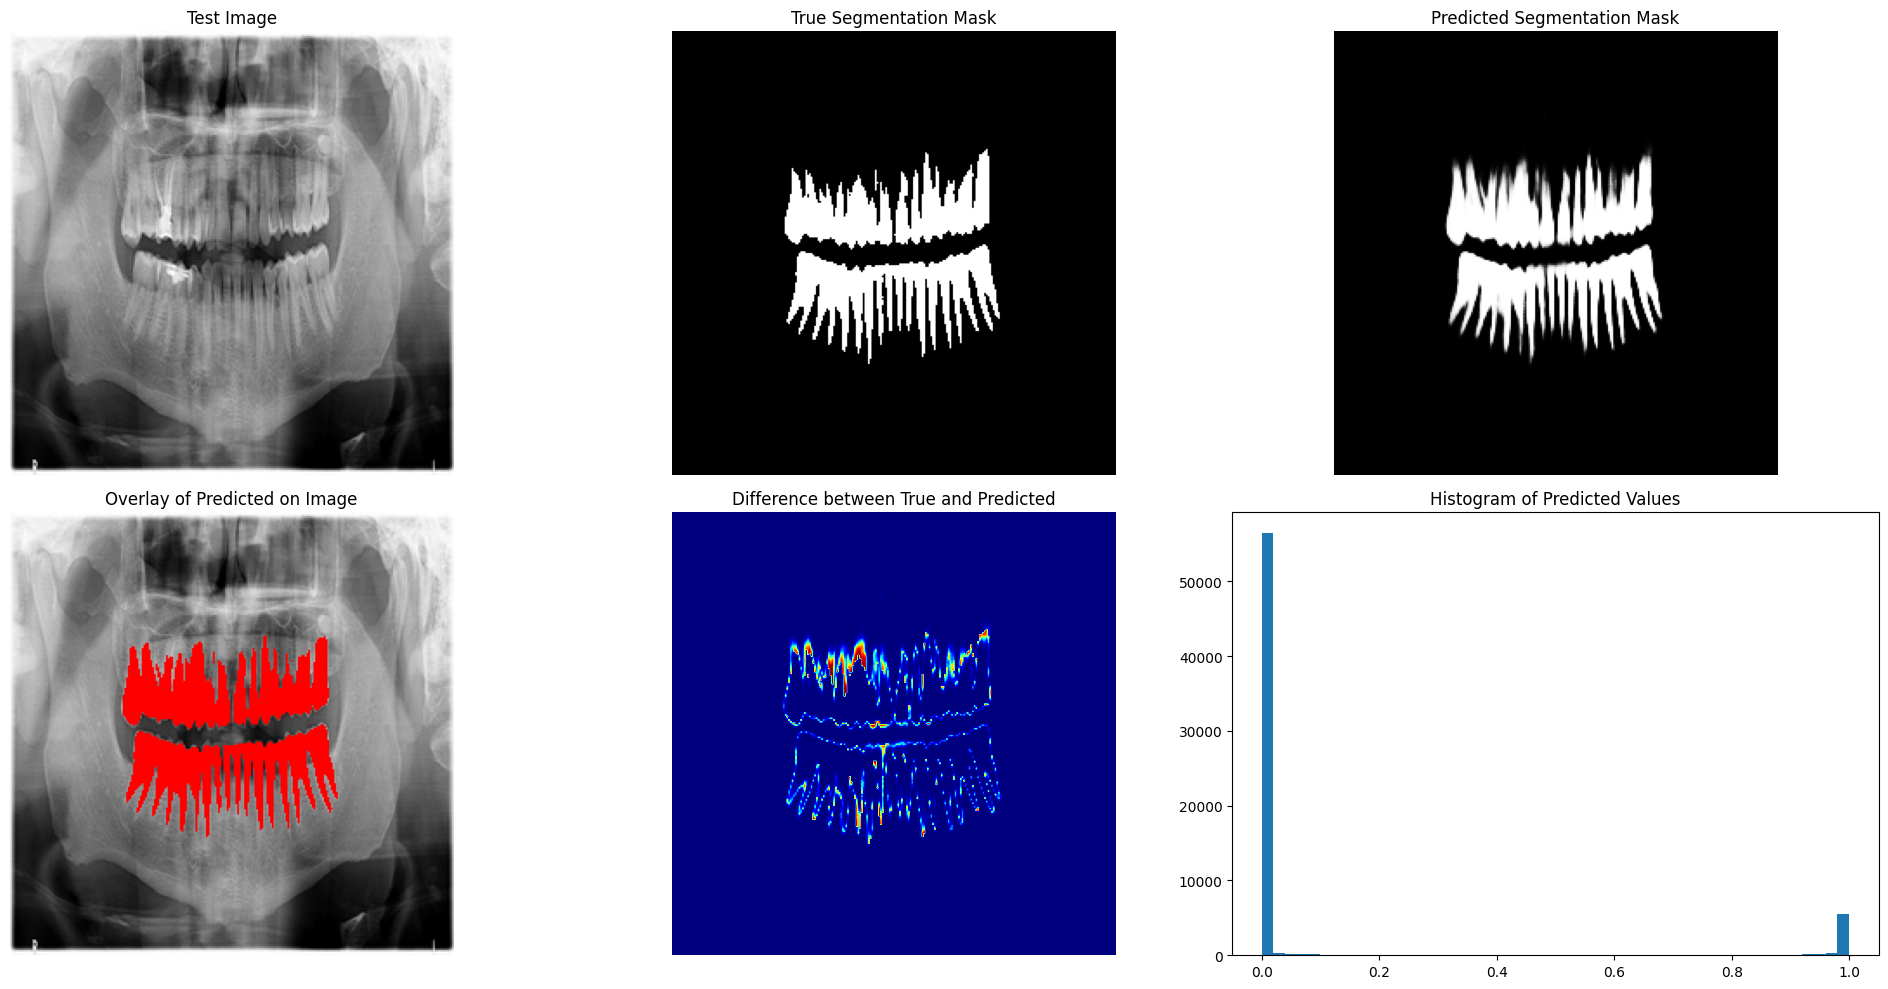

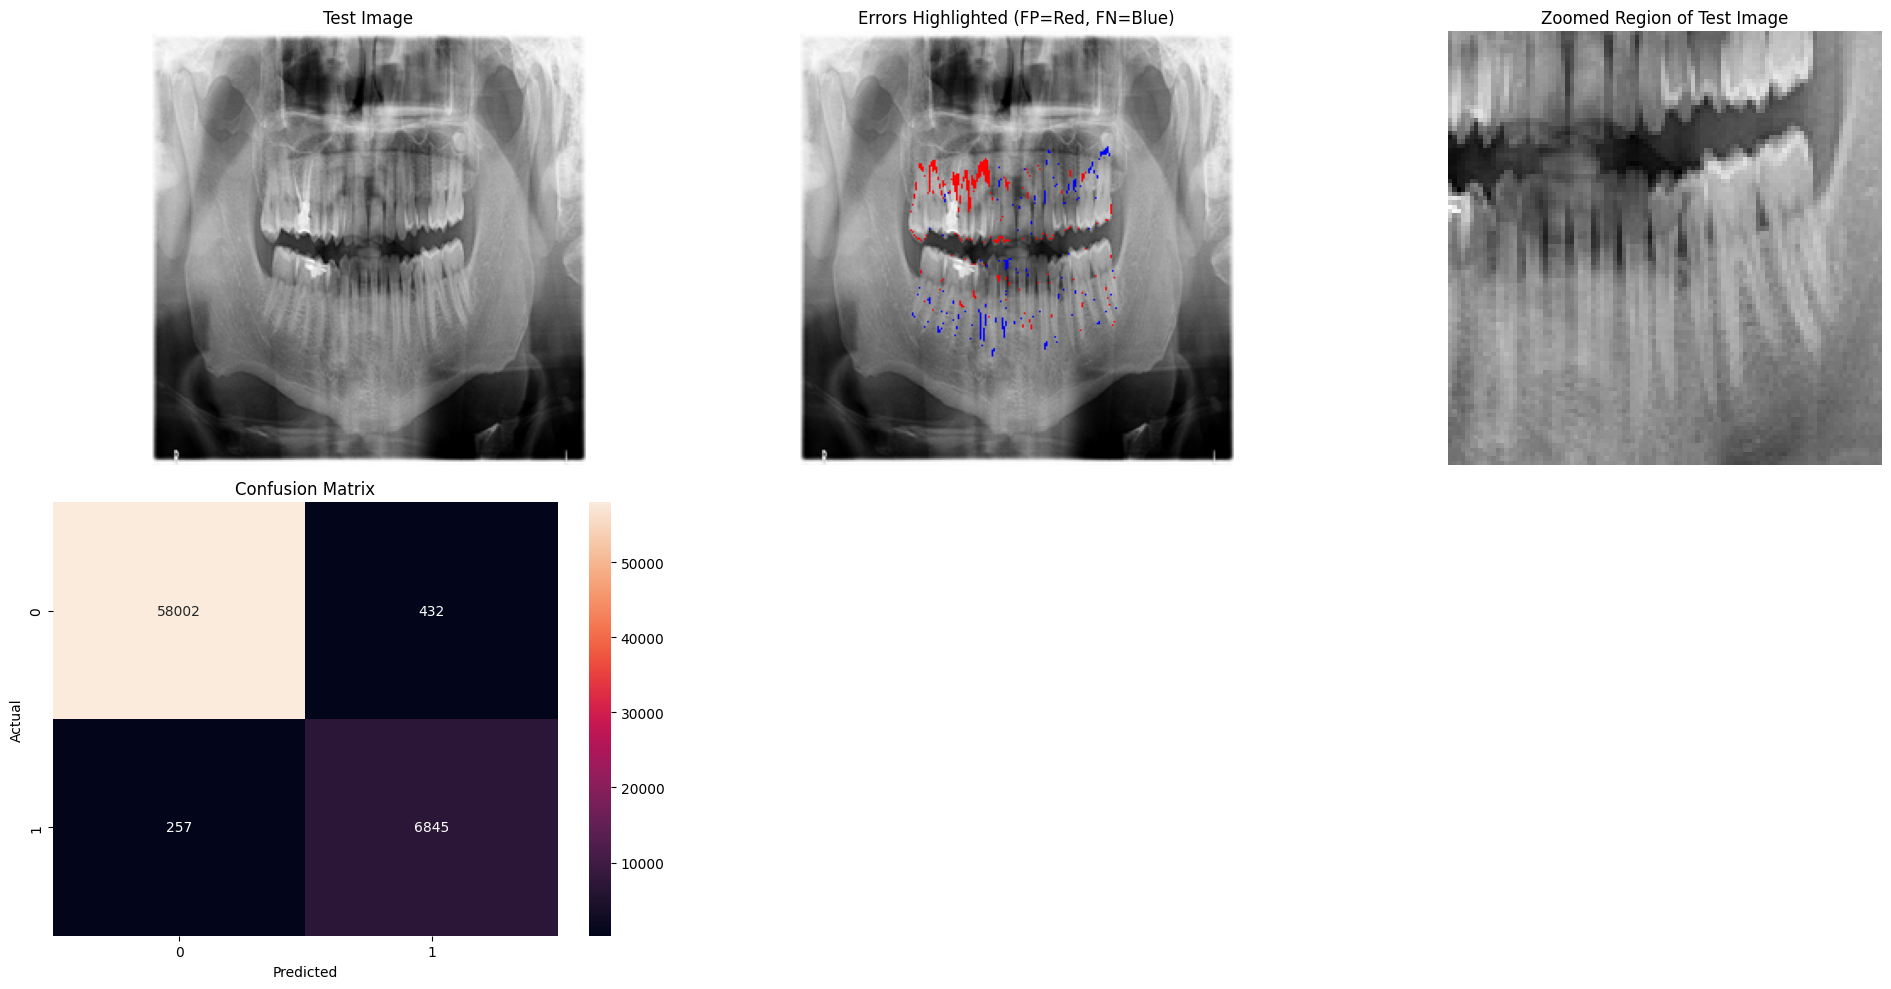

In [ ]:
visualizer = Visualization()
visualizer.visualize_images(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])
visualizer.detailed_visualization(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])
visualizer.advanced_visualization(normalized_images_test[1,:,:,0], normalized_masks_test[1,:,:,0], predicted_mask[1,:,:,0])